In [69]:
# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt


# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from mne_bids import BIDSPath
from mne import EpochsArray
from mne.viz import plot_compare_evokeds
from copy import deepcopy
import mne
from statsmodels.formula.api import mixedlm


from scipy.stats import ttest_ind


# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


# import summary_df from csv file
summary_df = pd.read_csv("global_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore.csv")
stats_df = pd.read_csv("individual_mean_stddev_zscore_nocrop.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore_negcorr.csv")



# Preprocessing

In [70]:

def individual_analysis(bids_path):
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']
    
    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")
    
    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]
    
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))
    
    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")
    
    raw_intensity_cropped = cropped_intensity.copy()

    
    
    # Remove break annotations
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])
    
    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 
    
    
    
    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)
    
    # get the total number of short channels
    short_chs = get_short_channels(raw_od)
    tot_number_of_short_channels = len(short_chs.ch_names)
    

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.7, h_freq=1.45)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.8))
    
    if len(bad_channels) > 55:
        print(f"❌ Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None, None, None, None, None
    
    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels
 
    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)

    
     # Get long channels
    long_chs = get_long_channels(raw_od)
    bad_long_chs = long_chs.info["bads"]
    
    len_bad_short_chs = len(bad_channels) - len(bad_long_chs)
    num_good_short_channels = tot_number_of_short_channels - len_bad_short_chs

    # Determine if there are short channels
    if num_good_short_channels < 4:
        print("❌ No short channels found. Skipping the subject.")
        return None, None, None, None, None # Keep the data unchanged
    else:
        raw_od_corrected = short_channel_regression(raw_od)
        
    
    # Convert to haemoglobin and filter    
        
    raw_haemo = beer_lambert_law(raw_od_corrected, ppf=0.1)
    
    raw_haemo = get_long_channels(raw_haemo, min_dist=0.02) 
    
    # negative correlation enhancement
    #raw_haemo = enhance_negative_correlation(raw_haemo)
    
           
    raw_haemo = raw_haemo.filter(l_freq = None, h_freq = 0.2,  
                                 method="iir", iir_params =dict(order=5, ftype='butter'))
    raw_haemo= raw_haemo.filter(l_freq =  0.05, h_freq = None, method="iir", iir_params =dict(order=5, ftype='butter')) #t0.05 was cutoff in andreas analysis
      
    # Create events and epochs
    events, event_dict = events_from_annotations(
        raw_haemo, verbose=False, regexp="^(?![Ends]).*$"
    )
    epochs = Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=-3,
        tmax=14,
        reject=dict(hbo=100e-6),
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        detrend=1,
        preload=True,
        verbose=None,
    )

    return raw_haemo, epochs, event_dict, raw_od, events

# Epoch Rejection

## Individual Level-zscore

In [71]:
def reject_epochs_zscore_individual(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0):
    """
    Rejects epochs based on z-score threshold using subject/session/condition-specific stats from stats_df.

    Parameters:
        data (ndarray): (n_epochs, n_times) or (n_epochs,) averaged data per epoch
        subject (str): e.g., "sub-01"
        session (str): e.g., "ses-01"
        condition_name (str): "Control", "Noise", or "Speech"
        stats_df (pd.DataFrame): DataFrame with per-participant mean and std
        z_thresh (float): Z-score threshold
        max_reject_ratio (float): Max proportion of epochs to reject

    Returns:
        cleaned_data (ndarray), rejected_indices (list)
    """
    row = stats_df[
        (stats_df["Subject"] == f"sub-{subject}") &
        (stats_df["Session"] == f"ses-{session}") &
        (stats_df["Condition"] == condition_name)
    ]

    if row.empty:
        raise ValueError(f"No stats found for {subject}, {session}, {condition_name}")

    mean = row["Mean_Amplitude"].values[0]
    std = row["SD_Amplitude"].values[0]

    z_scores = (data - mean) / std
    reject_mask = np.abs(z_scores) > z_thresh
    rejected_indices = np.where(reject_mask)[0].tolist()

    # Limit rejections
    max_reject = int(max_reject_ratio * data.shape[0])
    if len(rejected_indices) > max_reject:
        rejected_indices = rejected_indices[:max_reject]

    cleaned_data = np.delete(data, rejected_indices, axis=0)
    return cleaned_data, rejected_indices


## Group Level-zscore

In [40]:


def reject_epochs_zscore_global(data, condition_name, df= summary_df, z_thresh=3.0, max_reject_ratio=1.0):
    """
    Rejects epochs based on z-score threshold using global mean and std from summary_df.

    Parameters:
        data (ndarray): (n_epochs, n_channels) — max or min per channel per epoch
        condition_name (str): "Control", "Noise", or "Speech"
        summary_df (pd.DataFrame): Contains global mean/std per condition
        z_thresh (float): Z-score threshold for rejection
        max_reject_ratio (float): Max proportion of epochs to reject

    Returns:
        cleaned_data (ndarray), rejected_indices (list)
    """
    row = summary_df[summary_df["Condition"] == condition_name]
    if row.empty:
        raise ValueError(f"No global stats found for condition: {condition_name}")
    
    global_mean = row["Global_Mean"].values[0]
    global_std = row["Global_Std"].values[0]

    z_scores = (data - global_mean) / global_std
    reject_mask = np.abs(z_scores) > z_thresh
    #epoch_reject_flags = np.any(reject_mask)
    rejected_indices = np.where(reject_mask)[0].tolist()

    # Limit number of rejected epochs
    max_reject = int(max_reject_ratio * data.shape[0])
    if len(rejected_indices) > max_reject:
        rejected_indices = rejected_indices[:max_reject]

    cleaned_data = np.delete(data, rejected_indices, axis=0)
    return cleaned_data, rejected_indices


# Full preprocessing function

In [72]:
def full_preprocessing_individual(bids_path, z_thresh=2, stats_df=None):
    
    raw_haemo, epochs, event_dict, raw_od, events = individual_analysis(bids_path)

    if raw_haemo is None or epochs is None or len(epochs) < 10:
        print(f"⚠️ Skipping {bids_path.basename} (insufficient or failed data)")
        return None

    sub = bids_path.subject
    ses = bids_path.session

    # Drop bad channels, pick HbO only, and crop
    epochs.drop_channels(epochs.info['bads'])
    epochs_cleaned = epochs.copy().pick("hbo")
    #epochs_cleaned.crop(tmin=0.0, tmax=10.0)

    # Prepare data for rejection
    #data = epochs_cleaned.get_data(tmin=0.0, tmax=10.0).mean(axis=1)
    data = epochs_cleaned.get_data().mean(axis=1)
    data_mean = data.mean(axis=1)
    ev = epochs_cleaned.events[:, 2]
    labels = np.hstack((np.arange(len(ev)).reshape(-1, 1), ev.reshape(-1, 1)))

    conditions = {1: "Control", 2: "Noise", 3: "Speech"}
    all_rejected = []

    for cond_code, cond_name in conditions.items():
        cond_idx = labels[labels[:, 1] == cond_code][:, 0].astype(int)
        cond_data = data_mean[cond_idx]

        try:
            cleaned, rejected = reject_epochs_zscore_individual(
                cond_data,
                subject=sub,
                session=ses,
                condition_name=cond_name,
                stats_df=stats_df,
                z_thresh=z_thresh
            )
        except ValueError as e:
            print(f"⚠️ {e}")
            continue

        rejected_indices = [cond_idx[i] for i in rejected]
        all_rejected.extend(rejected_indices)
        print(f"Subject {sub}, Session {ses} - Rejected {len(rejected)} epochs in {cond_name}")

    # Drop bad epochs
    epochs_cleaned.drop(all_rejected)

    return epochs_cleaned, event_dict


# WAA Data-driven ROIs Construction
Single Optode Significance Analysis

In [73]:
def run_lme_per_session(data, session_label):
    subset_session = data[(data["Chroma"] == "hbo") & (data["Session"] == session_label)]
    optodes = subset_session["Optode"].unique()

    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["ID"].nunique() < 2:
            print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("Value ~ Condition", subset, groups=subset["Subject"])
            result = model.fit(method="nm")

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["ID"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt} (Session {session_label}): {e}")

    return pd.DataFrame(results_summary)

In [74]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

        # Construction of WAA Data-driven ROIS --> Single Optode Significance Testing
        optode_rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }
        
        df = pd.DataFrame(columns=["ID", "Subject", "Session", "Optode", "Chroma", "Condition", "Value"])

        id=id+1 
        
        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()

            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in optode_rois.items():
                # Keep only optodes that exist in this subject/session
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                
                if not valid_optodes:
                    #print(f"⚠️ Optode'{roi_name}' marked as bad in Subject {sub}. Skipping this Optode.")
                    continue  # Skip if no optodes available

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=4, tmax=6.0).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "Optode": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
                        
                    

                    except Exception as e:
                        print(f"❌ Failed to process Optode '{roi_name}' with error: {e}")
                    
        all_data = pd.concat([all_data, df], ignore_index=True)



                    
# Run LME for each session
results_ses01_df = run_lme_per_session(all_data, "01")

results_ses02_df = run_lme_per_session(all_data, "02")




Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 2 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 2 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 0

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: T

In [75]:
# save all_data to csv
all_data.to_csv("all_subjects_evoked_values_optodes.csv", index=False)

In [61]:
def get_significant_optodes_by_condition(df, session_label):
    speech_sig = df[df["PValue_Condition[T.Speech]"] < 0.05].copy()
    noise_sig = df[df["PValue_Condition[T.Noise]"] < 0.05].copy()

    if speech_sig.empty:
        print("No significant optodes.")
    if noise_sig.empty:
        print("No significant optodes.")
    return speech_sig, noise_sig

# Run for both sessions
speech_sig_ses01, noise_sig_ses01 = get_significant_optodes_by_condition(results_ses01_df, "01")
speech_sig_ses02, noise_sig_ses02 = get_significant_optodes_by_condition(results_ses02_df, "02")

# === Find common optodes ===
common_speech_optodes = set(speech_sig_ses01["Optode"]) & set(speech_sig_ses02["Optode"])
common_noise_optodes = set(noise_sig_ses01["Optode"]) & set(noise_sig_ses02["Optode"])

print("\nCommon significant optodes for SPEECH (p < 0.05 in both sessions):")
if common_speech_optodes:
    for opt in sorted(common_speech_optodes):
        print(f" - {opt}")
else:
    print("None found.")

print("\nCommon significant optodes for NOISE (p < 0.05 in both sessions):")
if common_noise_optodes:
    for opt in sorted(common_noise_optodes):
        print(f" - {opt}")
else:
    print("None found.")




Common significant optodes for SPEECH (p < 0.05 in both sessions):
 - S10_D10
 - S10_D11
 - S10_D9
 - S5_D4

Common significant optodes for NOISE (p < 0.05 in both sessions):
 - S11_D11


# WAA Individual-Level Analysis (pre-defined vs data-driven ROIs)

## Plot Individual Signals accross ROIs

In [62]:
def plot_evoked_rois(evoked_dict, roi_definitions, title_prefix="", subject="", session=""):
    import matplotlib.pyplot as plt
    from mne.viz import plot_compare_evokeds

    # Number of ROIs (columns) to create
    fig, axes = plt.subplots(1, len(roi_definitions), figsize=(6 * len(roi_definitions), 5))
    if len(roi_definitions) == 1:
        axes = [axes]
    
    # Define colors for each condition
    condition_colors = {
        "Control": "r",  # Red for Control
        "Noise": "g",    # Green for Noise
        "Speech": "b"    # Blue for Speech
    }
    
    # Iterate through each ROI
    for ax, (roi_name, optodes) in zip(axes, roi_definitions.items()):
        # Create a dictionary to store evoked data for the legend
        evoked_for_legend = {}

        # For each condition, plot evoked responses with different colors
        for condition_name, evoked in evoked_dict.items():
            picks = [ch for ch in optodes if ch in evoked.ch_names]
            if not picks:
                print(f"⚠️ No channels found in ROI '{roi_name}' for {condition_name}")
                continue
            
            # Plot the evoked response for the current condition with the corresponding color
            plot_compare_evokeds(
                {condition_name: evoked},
                picks=picks,
                axes=ax,
                combine='mean',
                show=False,
                colors=[condition_colors.get(condition_name, 'k')],
                ylim=dict(hbo=[-5, 12])
            )

            evoked_for_legend[condition_name] = evoked
        
        # Set the title for the ROI plot
        ax.set_title(f"{title_prefix} ROI: {roi_name}\nSubject: {subject}, Session: {session}")
        
        # Create a legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Conditions")
    
    # Save the figure
    
    plt.show()


Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 2 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech


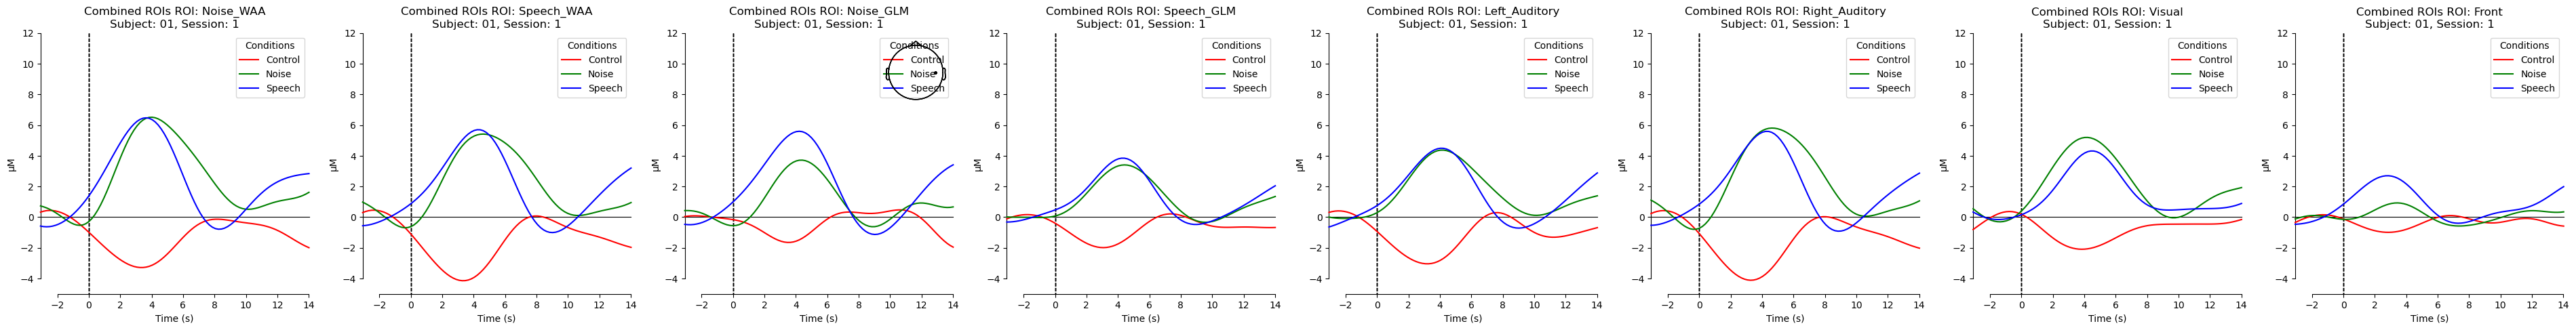

Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech


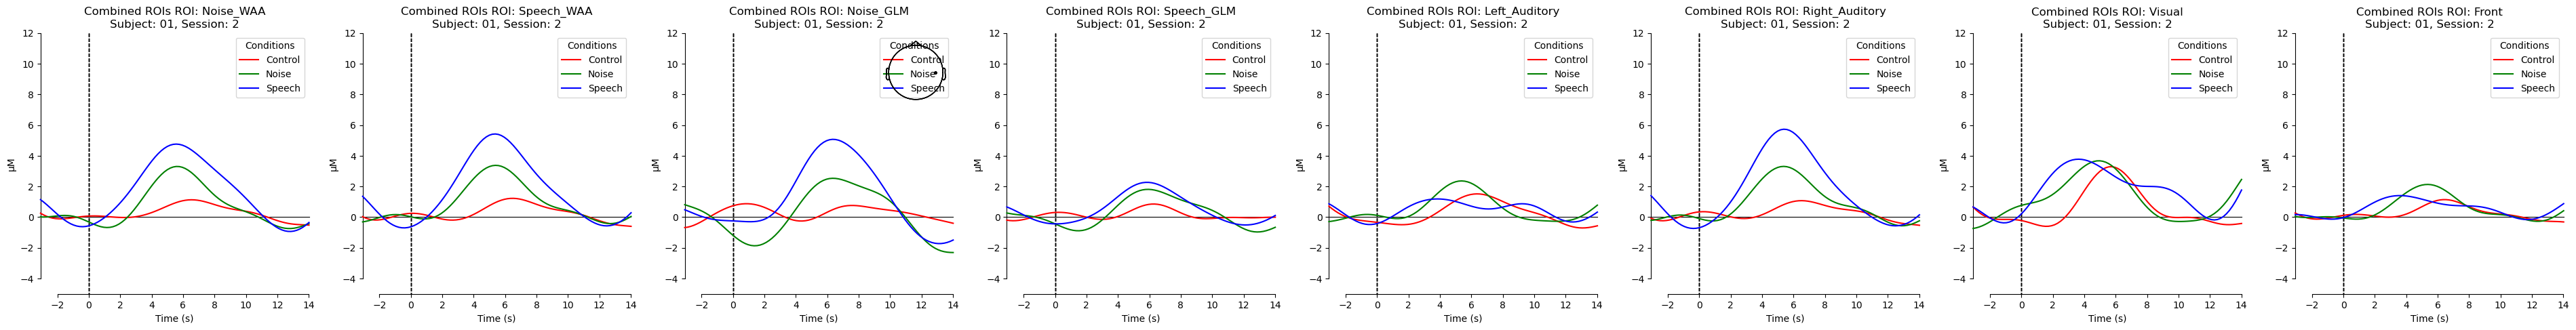

Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech


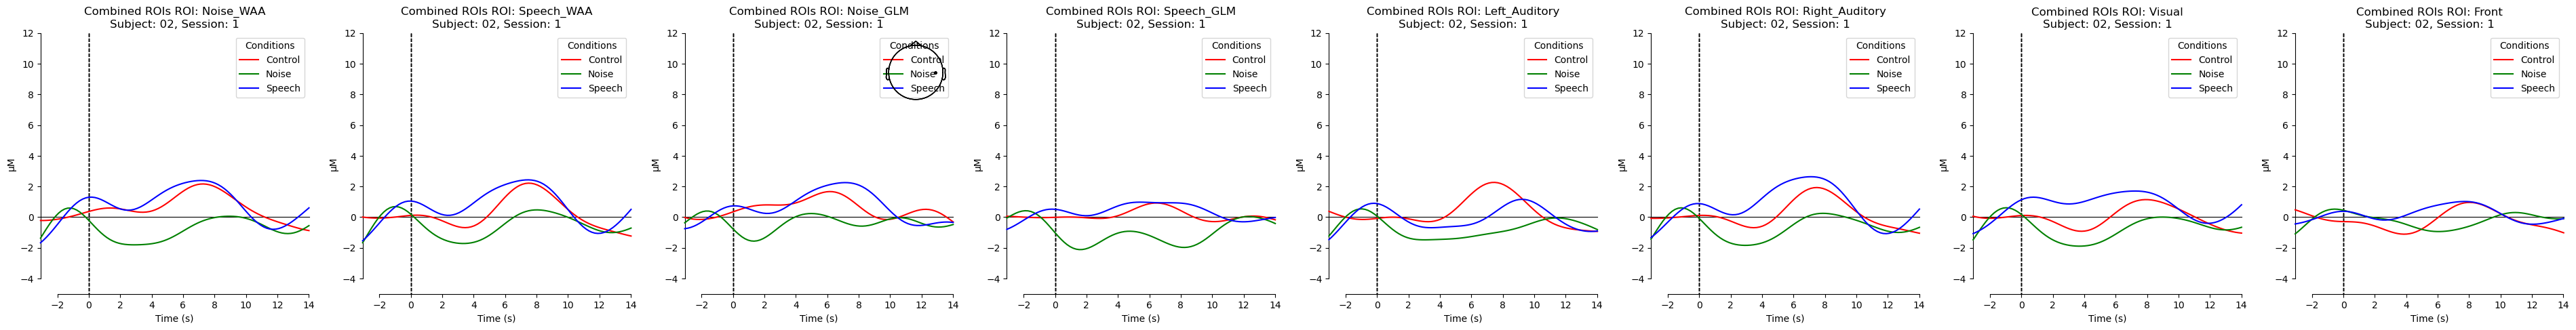

Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech


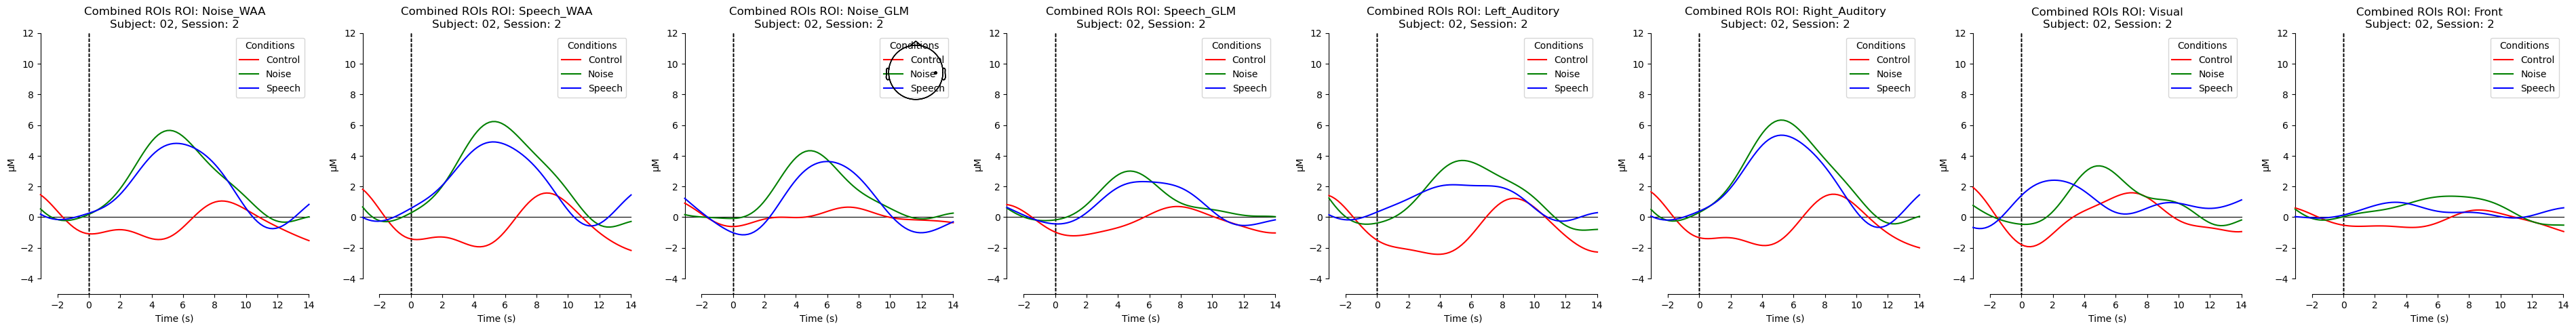

Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 2 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech


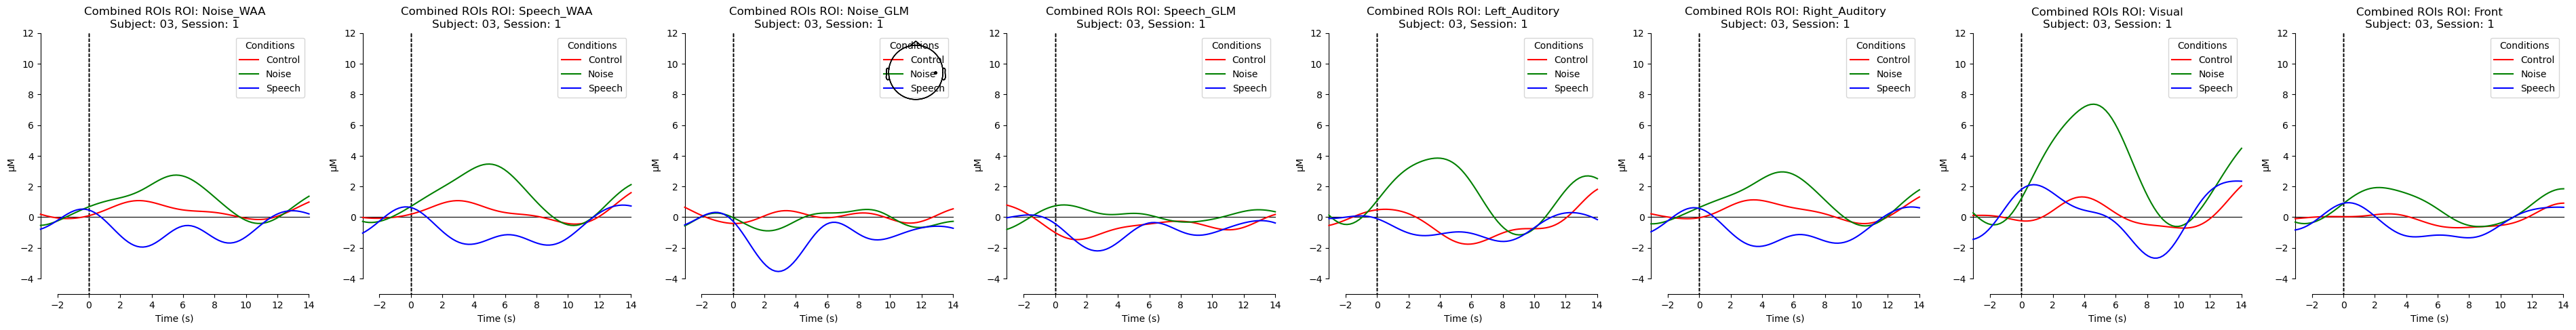

Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 0 epochs in Noise
Subject 03, Session 02 - Rejected 0 epochs in Speech


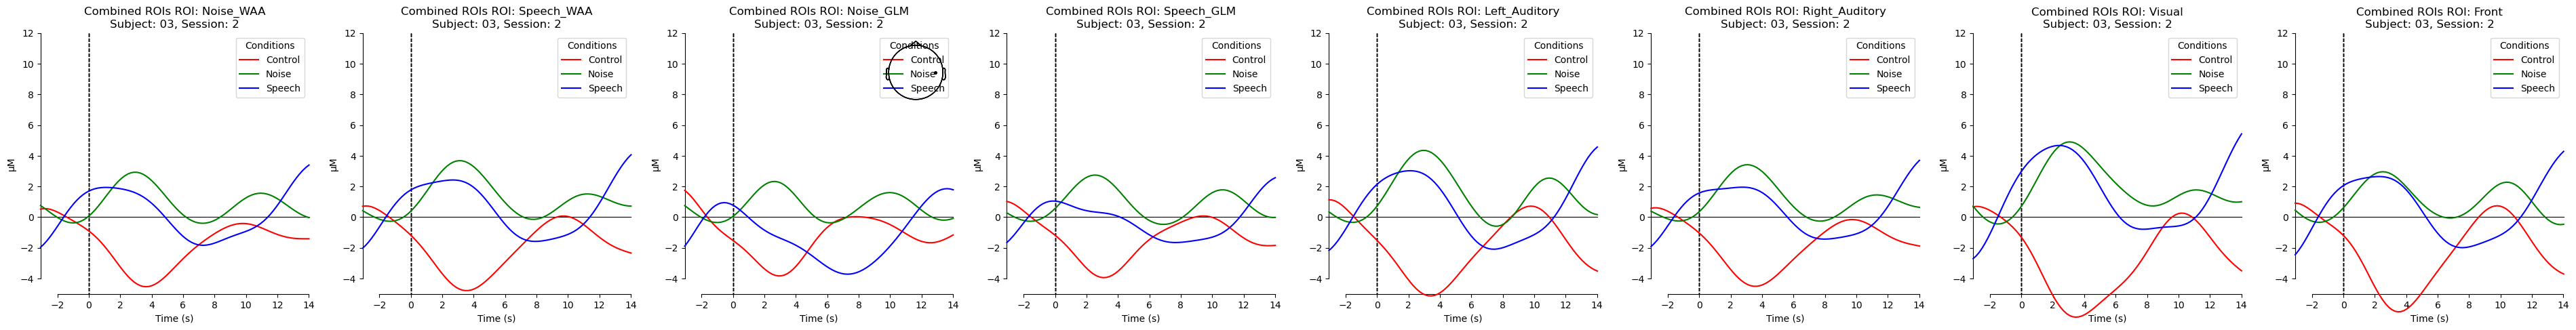

Subject 04, Session 01 - Rejected 1 epochs in Control
Subject 04, Session 01 - Rejected 2 epochs in Noise
Subject 04, Session 01 - Rejected 2 epochs in Speech


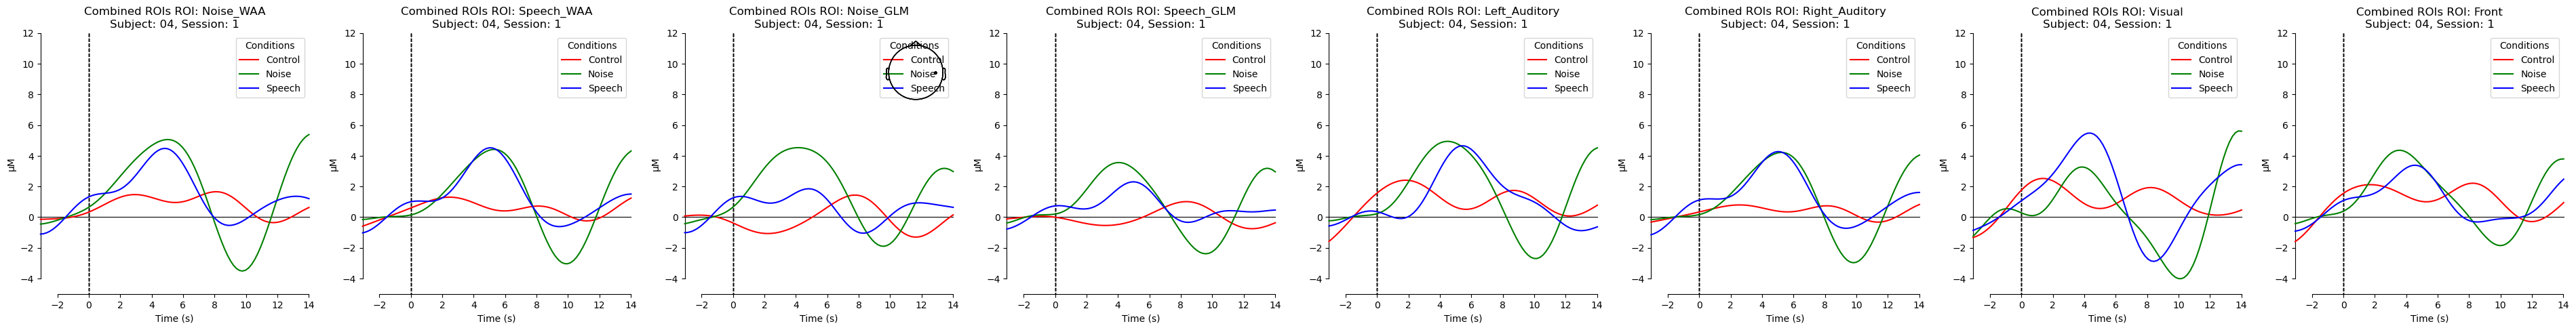

Subject 04, Session 02 - Rejected 0 epochs in Control
Subject 04, Session 02 - Rejected 1 epochs in Noise
Subject 04, Session 02 - Rejected 1 epochs in Speech


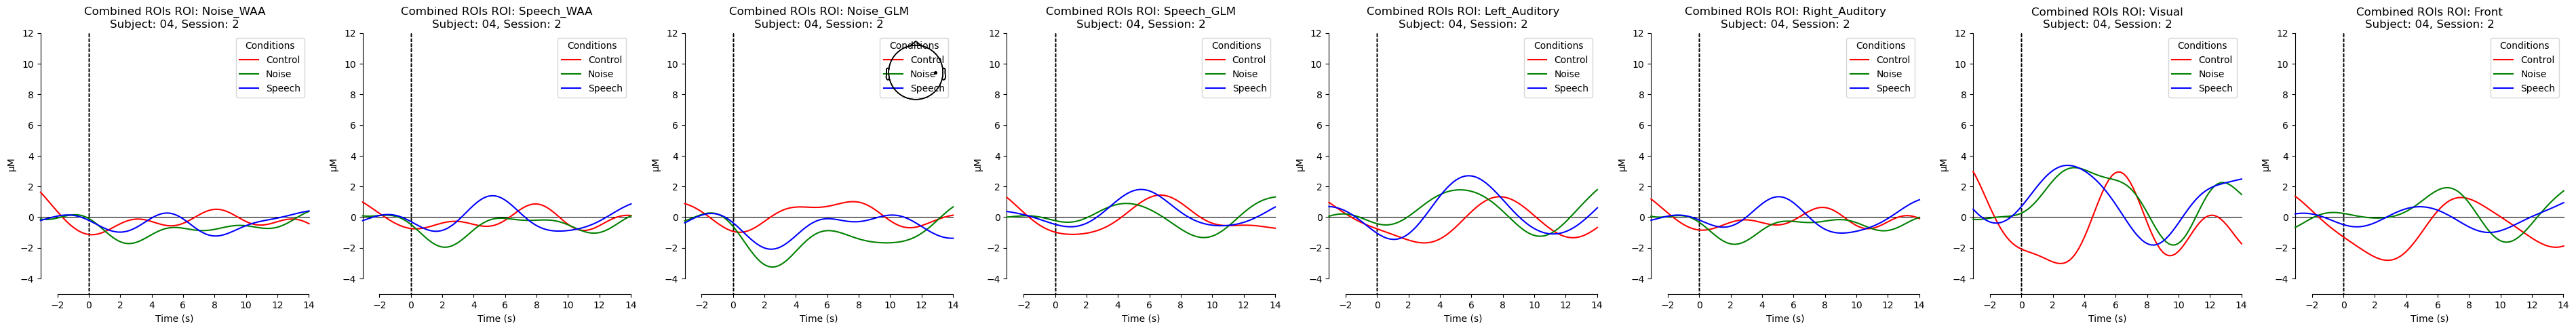

Subject 05, Session 01 - Rejected 1 epochs in Control
Subject 05, Session 01 - Rejected 1 epochs in Noise
Subject 05, Session 01 - Rejected 0 epochs in Speech


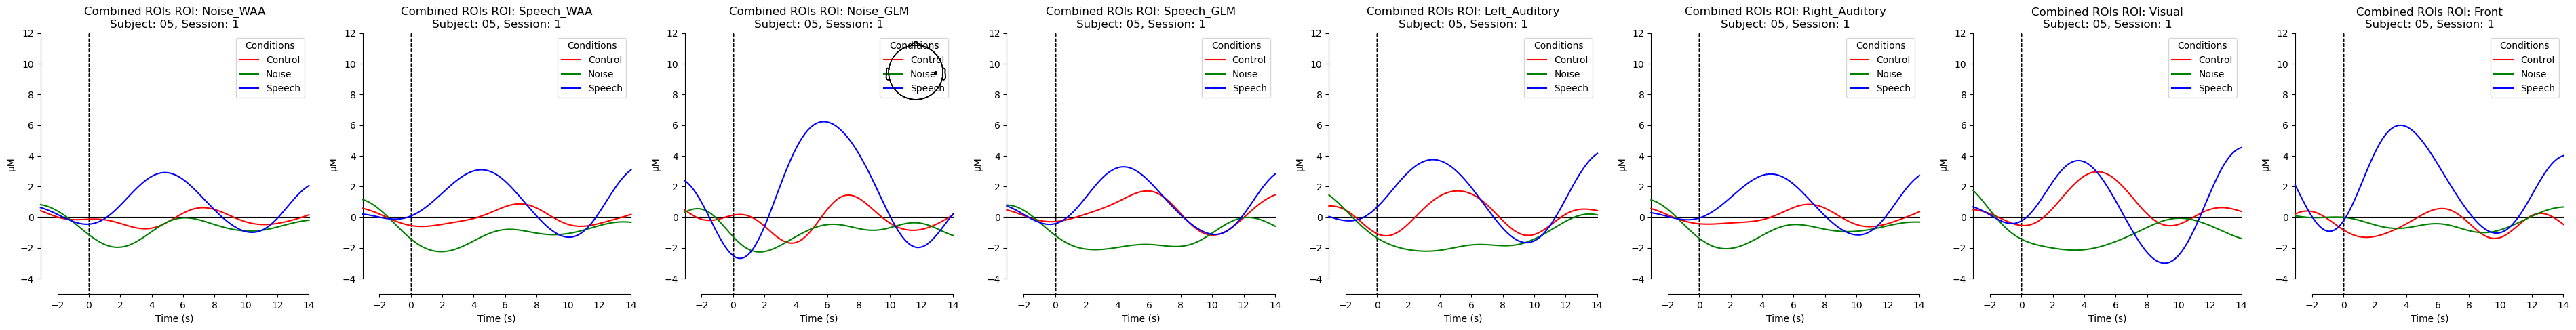

Subject 05, Session 02 - Rejected 0 epochs in Control
Subject 05, Session 02 - Rejected 0 epochs in Noise
Subject 05, Session 02 - Rejected 1 epochs in Speech


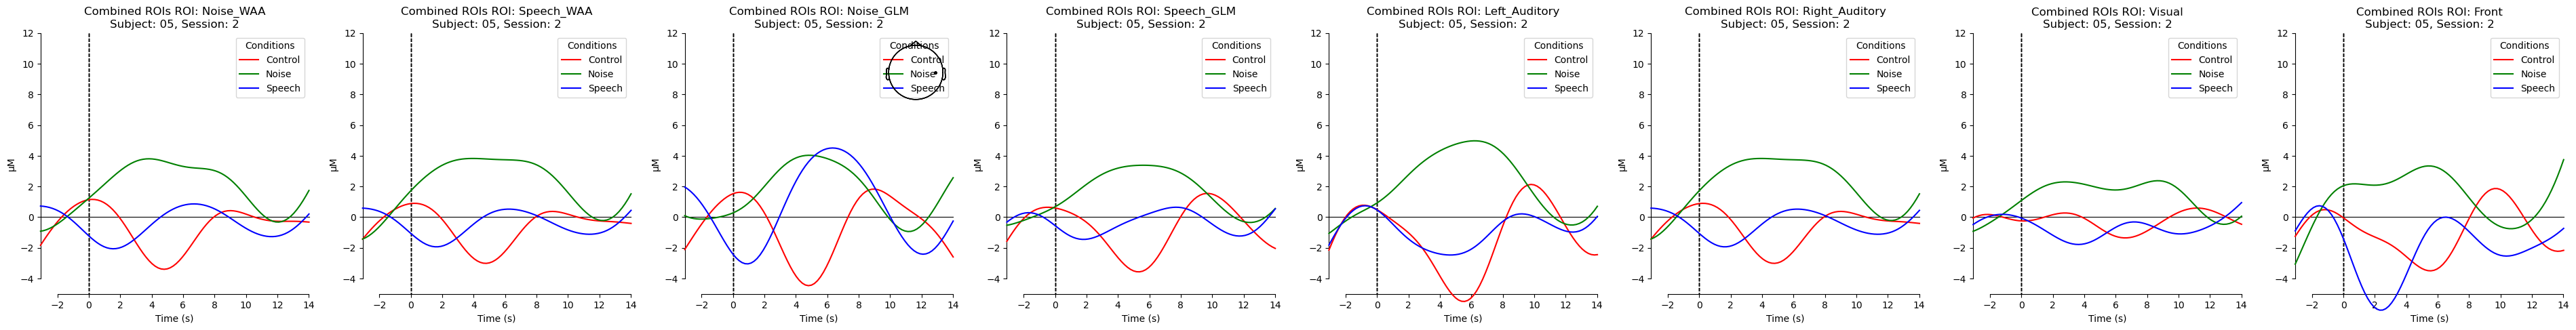

Subject 07, Session 01 - Rejected 0 epochs in Control
Subject 07, Session 01 - Rejected 1 epochs in Noise
Subject 07, Session 01 - Rejected 2 epochs in Speech


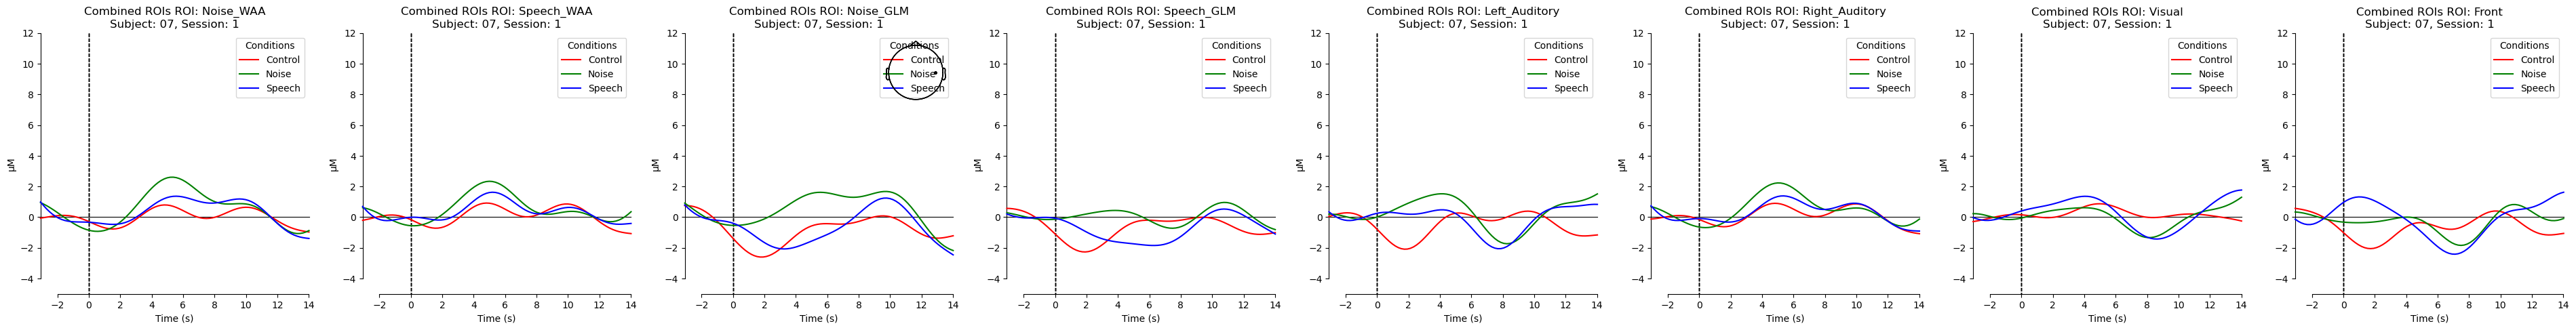

Subject 07, Session 02 - Rejected 2 epochs in Control
Subject 07, Session 02 - Rejected 0 epochs in Noise
Subject 07, Session 02 - Rejected 0 epochs in Speech


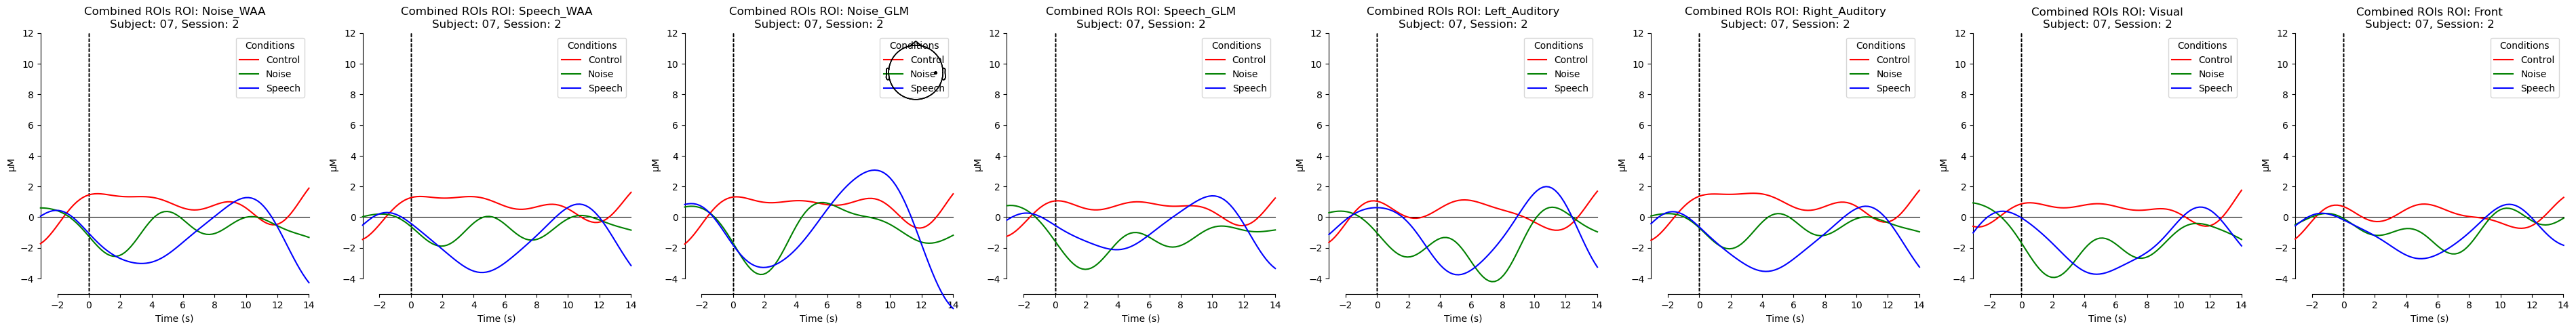

Subject 08, Session 01 - Rejected 1 epochs in Control
Subject 08, Session 01 - Rejected 1 epochs in Noise
Subject 08, Session 01 - Rejected 1 epochs in Speech


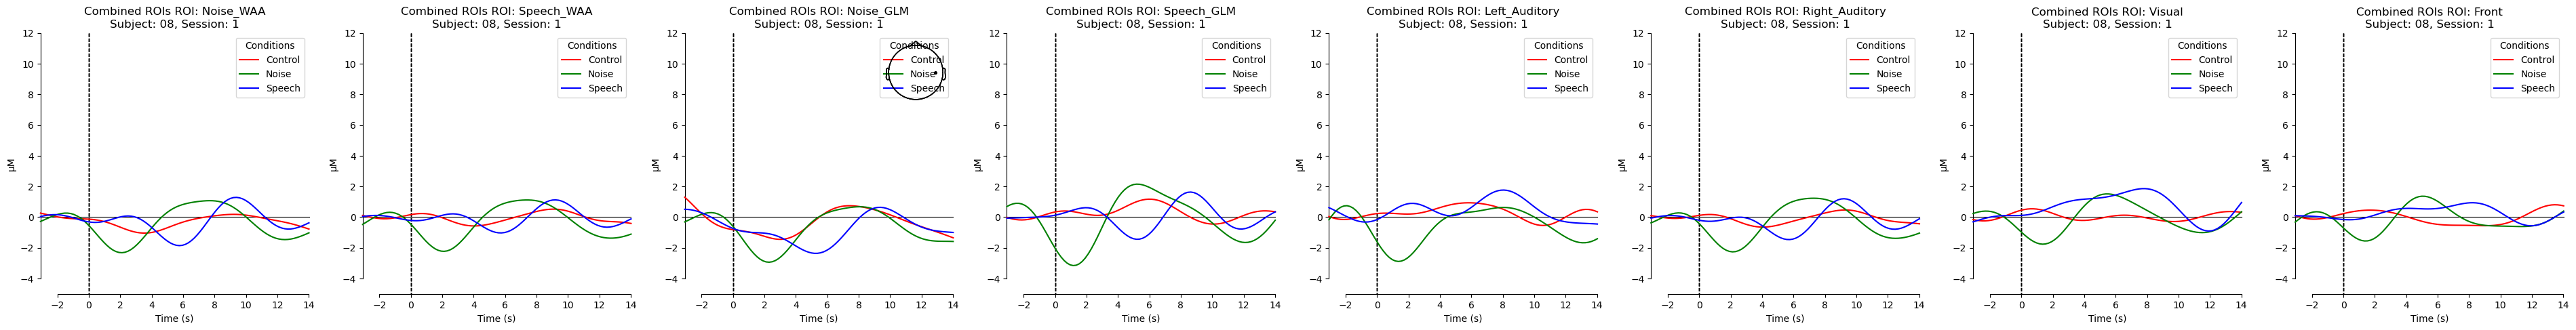

Subject 08, Session 02 - Rejected 1 epochs in Control
Subject 08, Session 02 - Rejected 1 epochs in Noise
Subject 08, Session 02 - Rejected 0 epochs in Speech


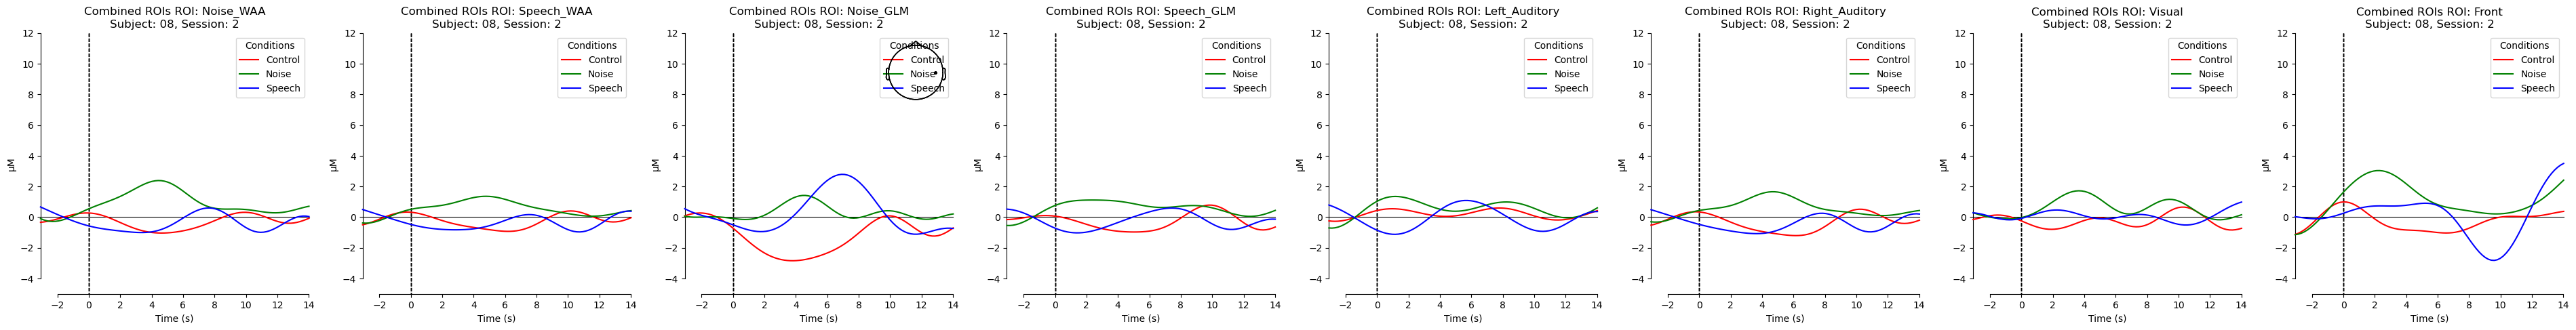

Subject 10, Session 01 - Rejected 1 epochs in Control
Subject 10, Session 01 - Rejected 1 epochs in Noise
Subject 10, Session 01 - Rejected 1 epochs in Speech


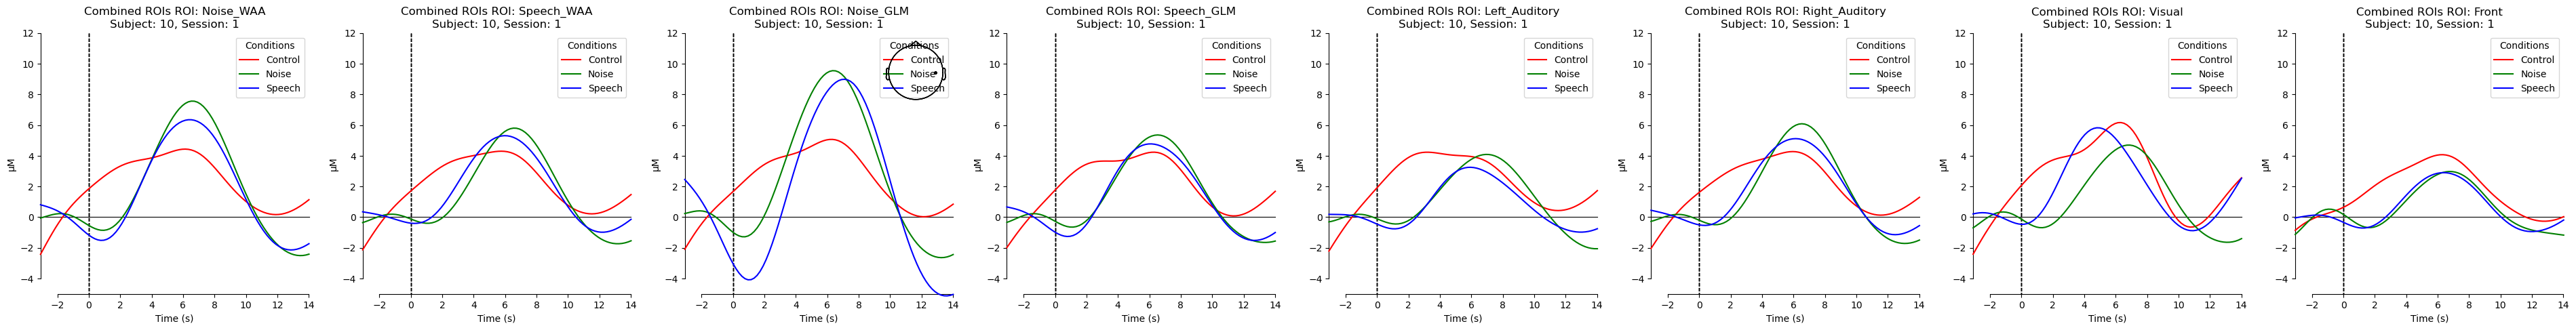

Subject 10, Session 02 - Rejected 1 epochs in Control
Subject 10, Session 02 - Rejected 0 epochs in Noise
Subject 10, Session 02 - Rejected 2 epochs in Speech


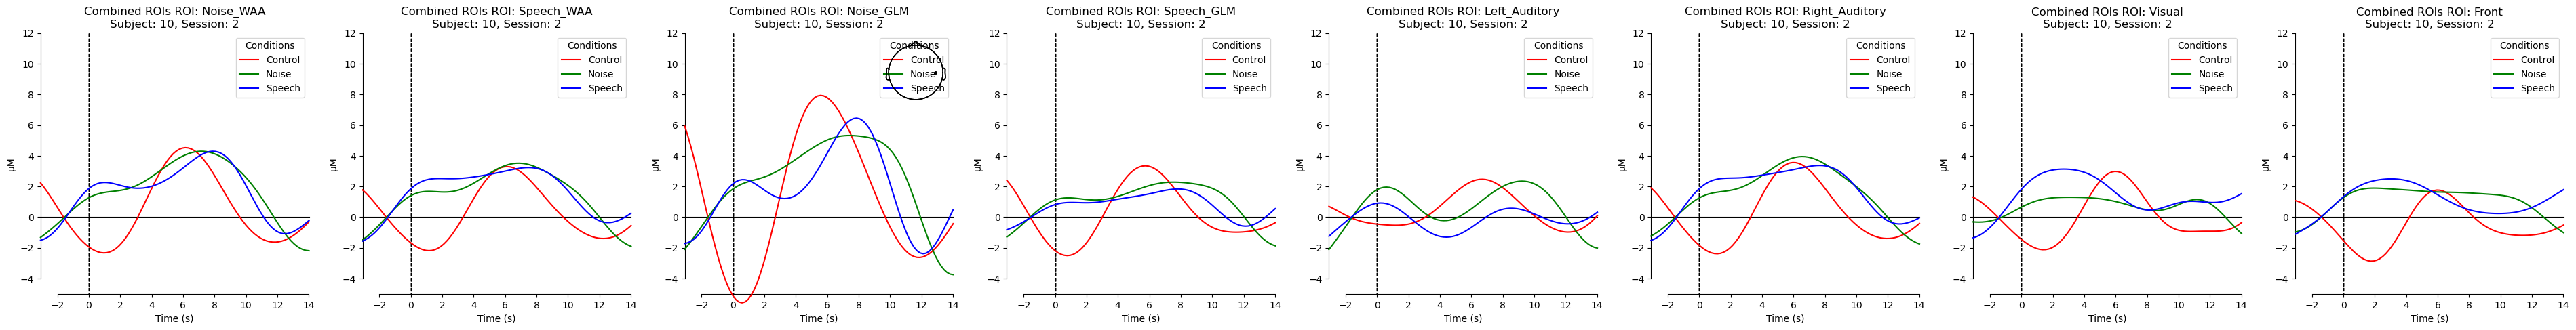

Subject 11, Session 01 - Rejected 0 epochs in Control
Subject 11, Session 01 - Rejected 1 epochs in Noise
Subject 11, Session 01 - Rejected 2 epochs in Speech


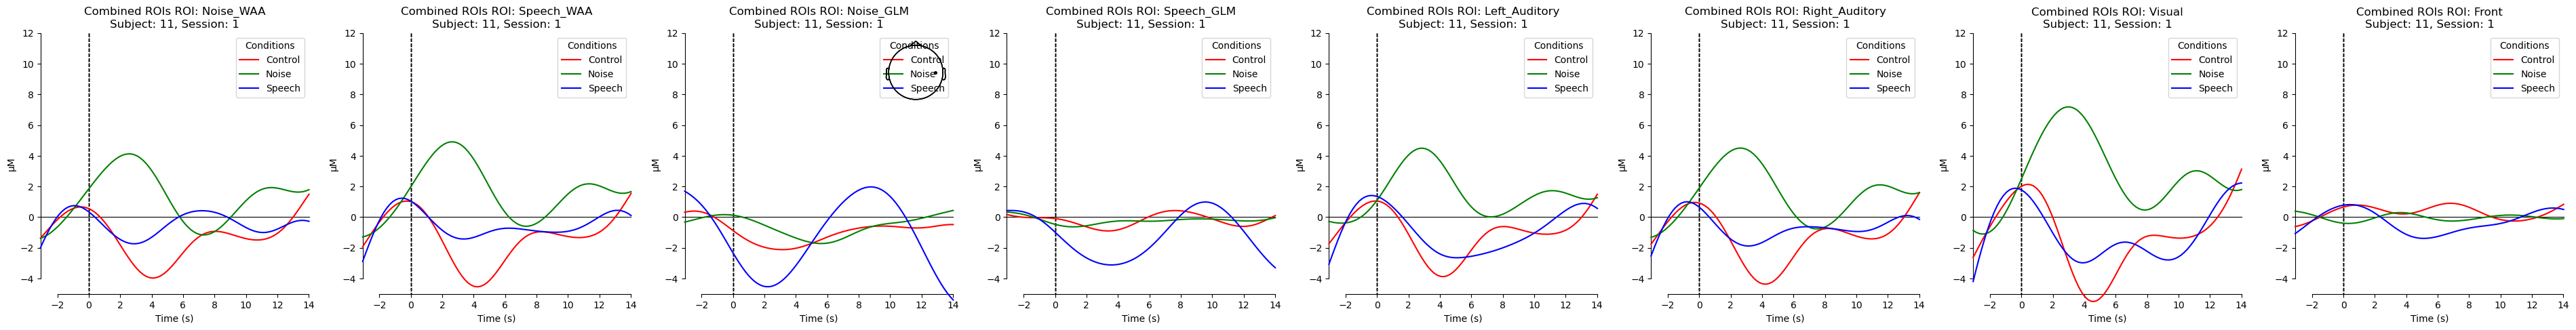

Subject 11, Session 02 - Rejected 0 epochs in Control
Subject 11, Session 02 - Rejected 0 epochs in Noise
Subject 11, Session 02 - Rejected 1 epochs in Speech


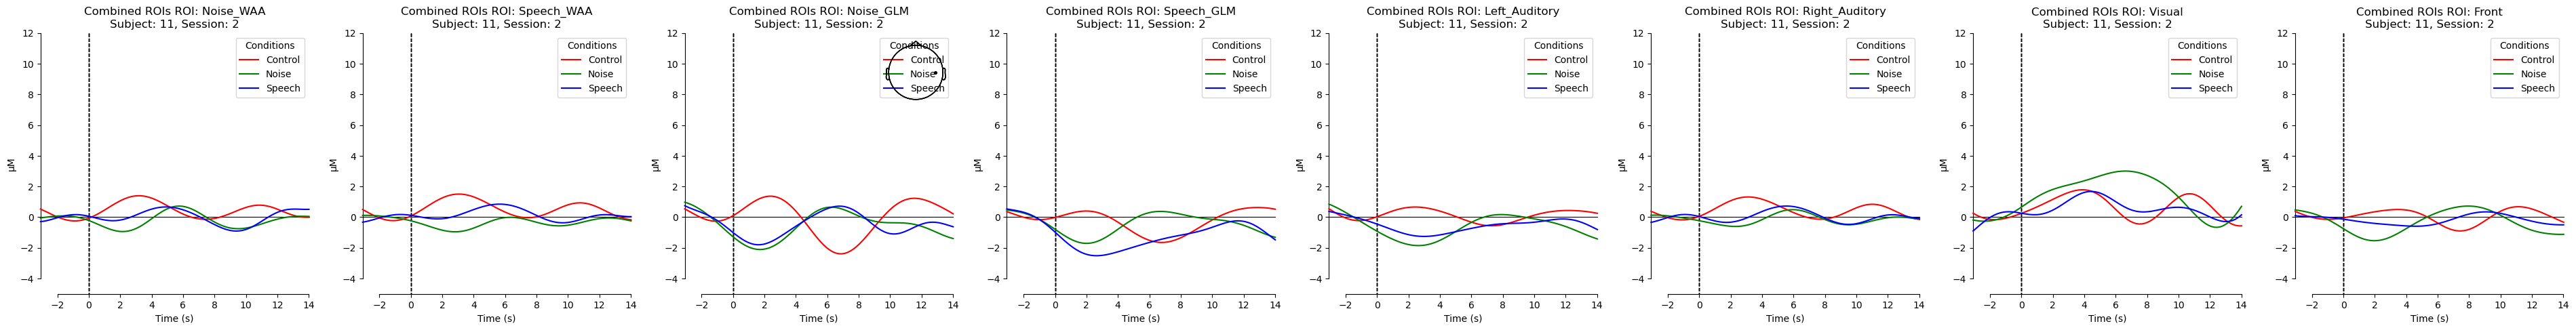

Subject 12, Session 01 - Rejected 0 epochs in Control
Subject 12, Session 01 - Rejected 0 epochs in Noise
Subject 12, Session 01 - Rejected 0 epochs in Speech


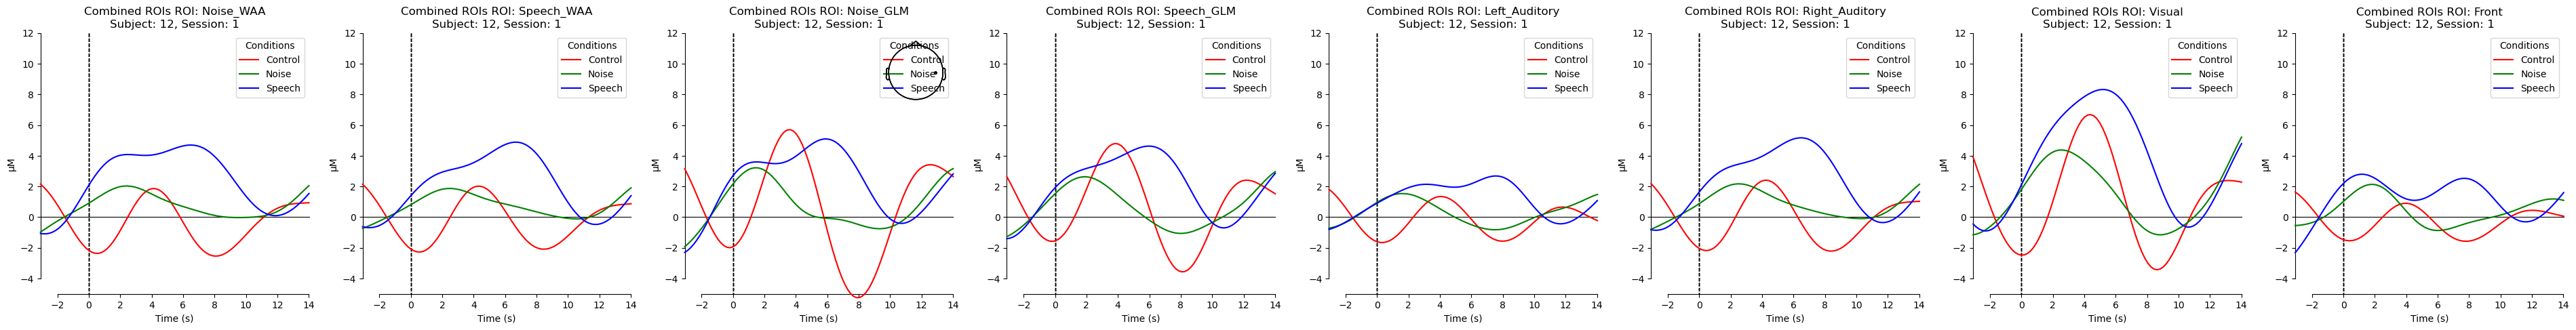

Subject 12, Session 02 - Rejected 1 epochs in Control
Subject 12, Session 02 - Rejected 1 epochs in Noise
Subject 12, Session 02 - Rejected 1 epochs in Speech


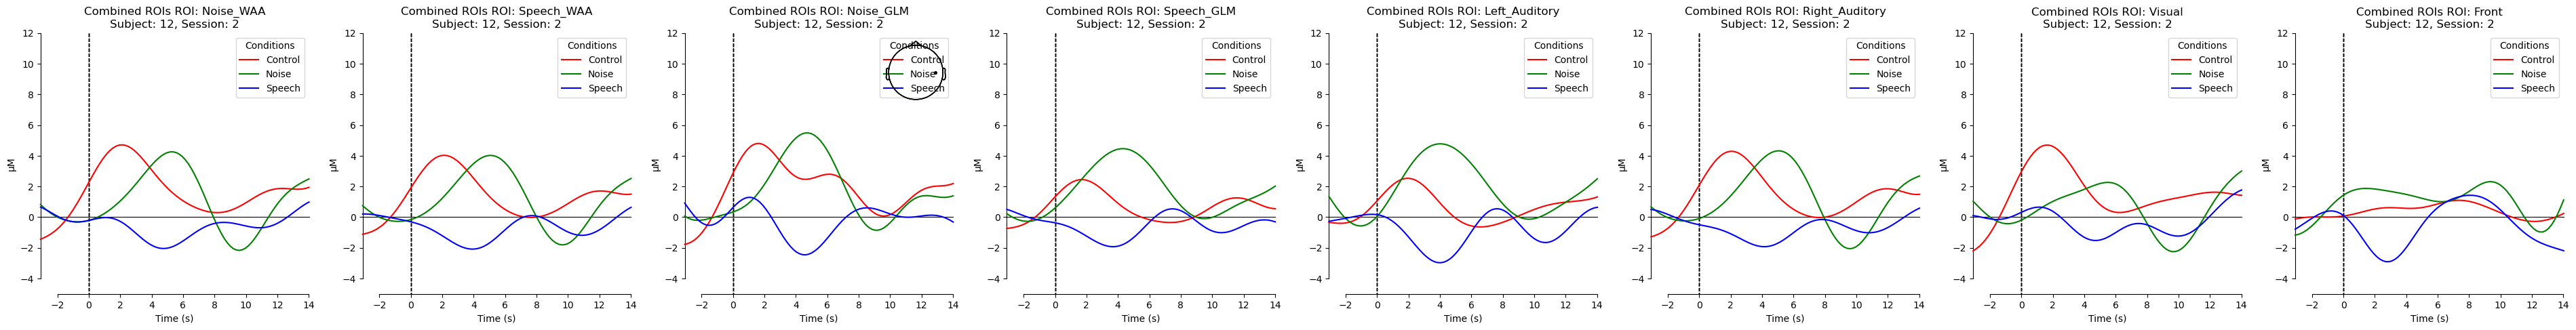

Subject 13, Session 01 - Rejected 0 epochs in Control
Subject 13, Session 01 - Rejected 0 epochs in Noise
Subject 13, Session 01 - Rejected 0 epochs in Speech


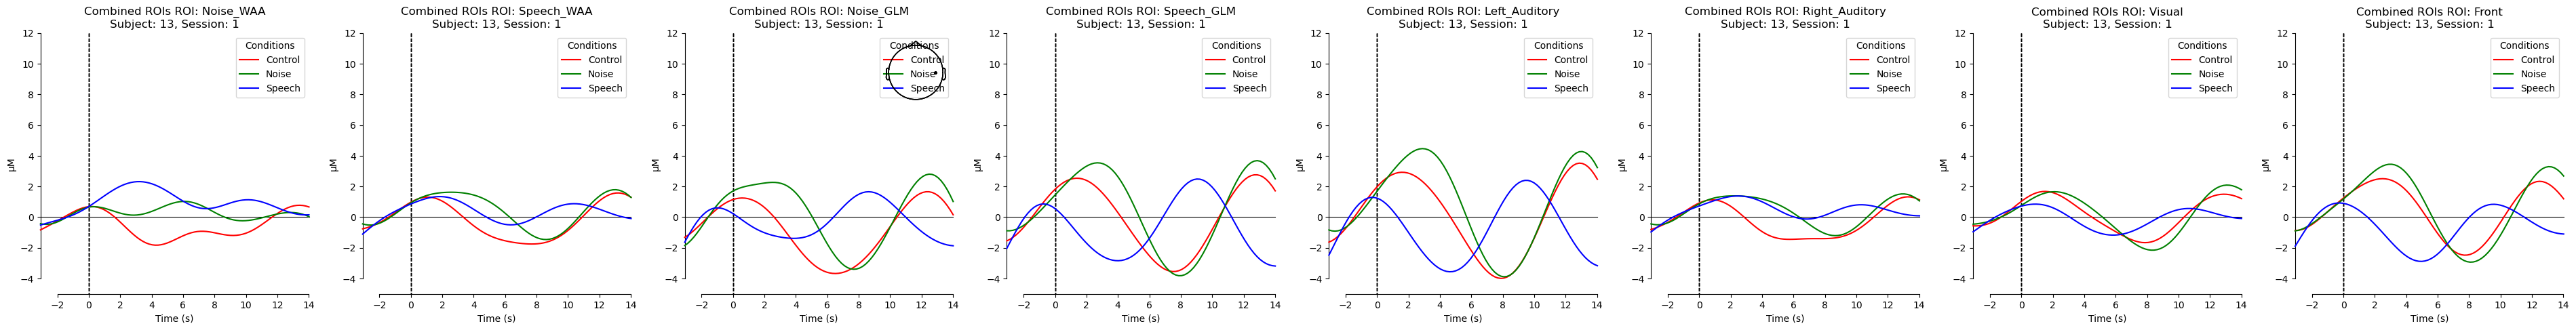

Subject 13, Session 02 - Rejected 0 epochs in Control
Subject 13, Session 02 - Rejected 0 epochs in Noise
Subject 13, Session 02 - Rejected 0 epochs in Speech


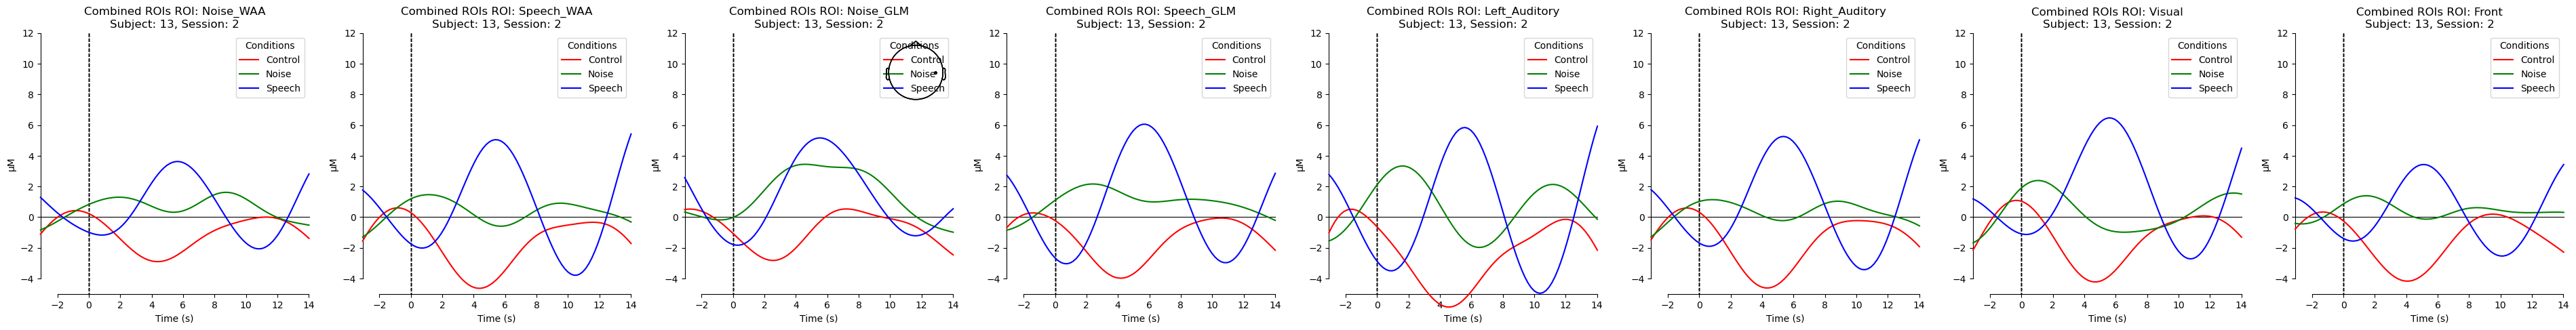

Subject 16, Session 01 - Rejected 2 epochs in Control
Subject 16, Session 01 - Rejected 1 epochs in Noise
Subject 16, Session 01 - Rejected 1 epochs in Speech


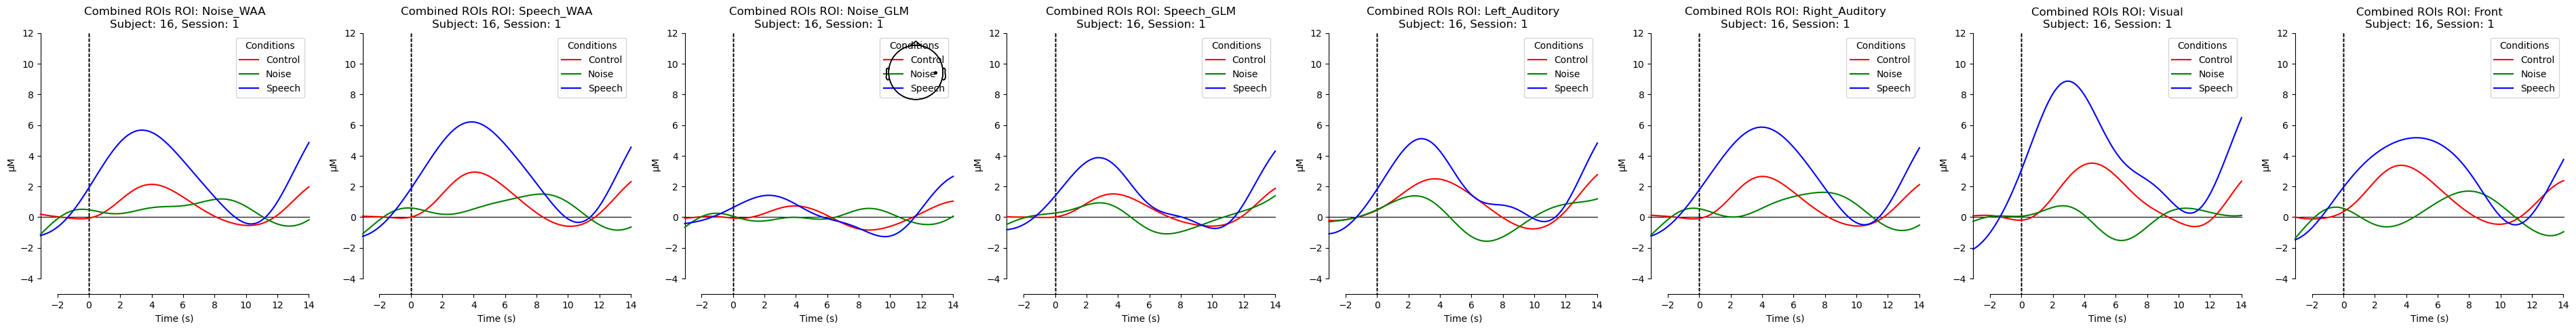

Subject 16, Session 02 - Rejected 1 epochs in Control
Subject 16, Session 02 - Rejected 1 epochs in Noise
Subject 16, Session 02 - Rejected 1 epochs in Speech


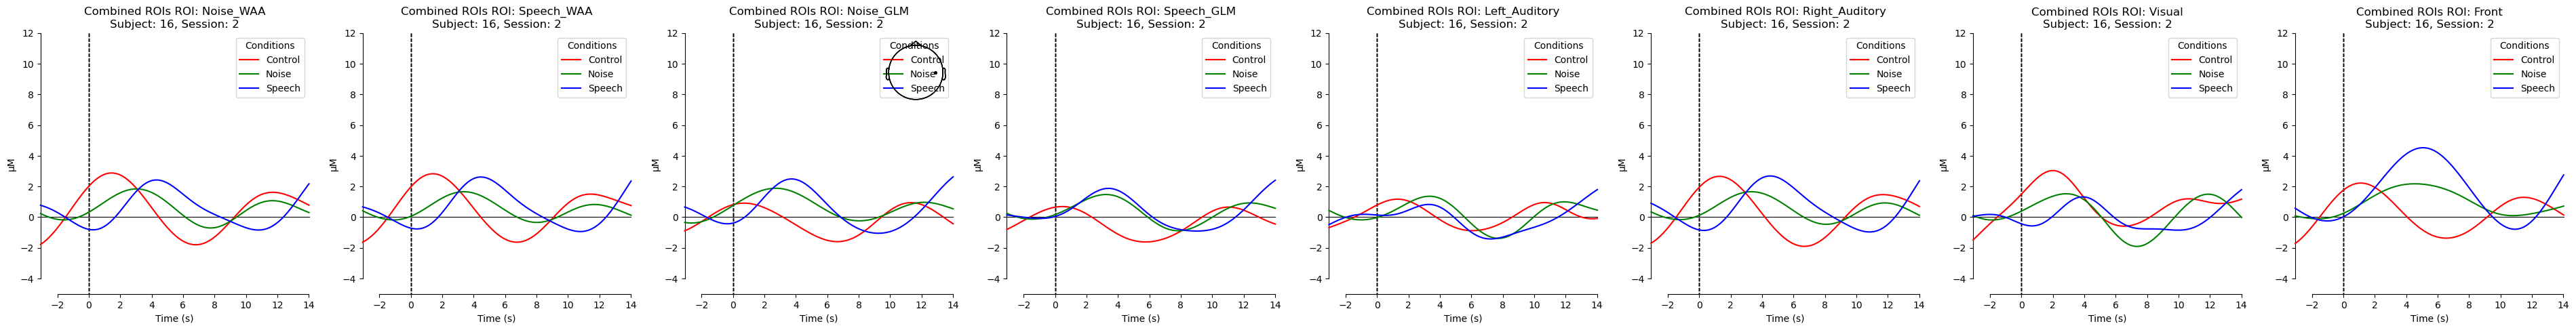

Subject 17, Session 01 - Rejected 0 epochs in Control
Subject 17, Session 01 - Rejected 0 epochs in Noise
Subject 17, Session 01 - Rejected 1 epochs in Speech


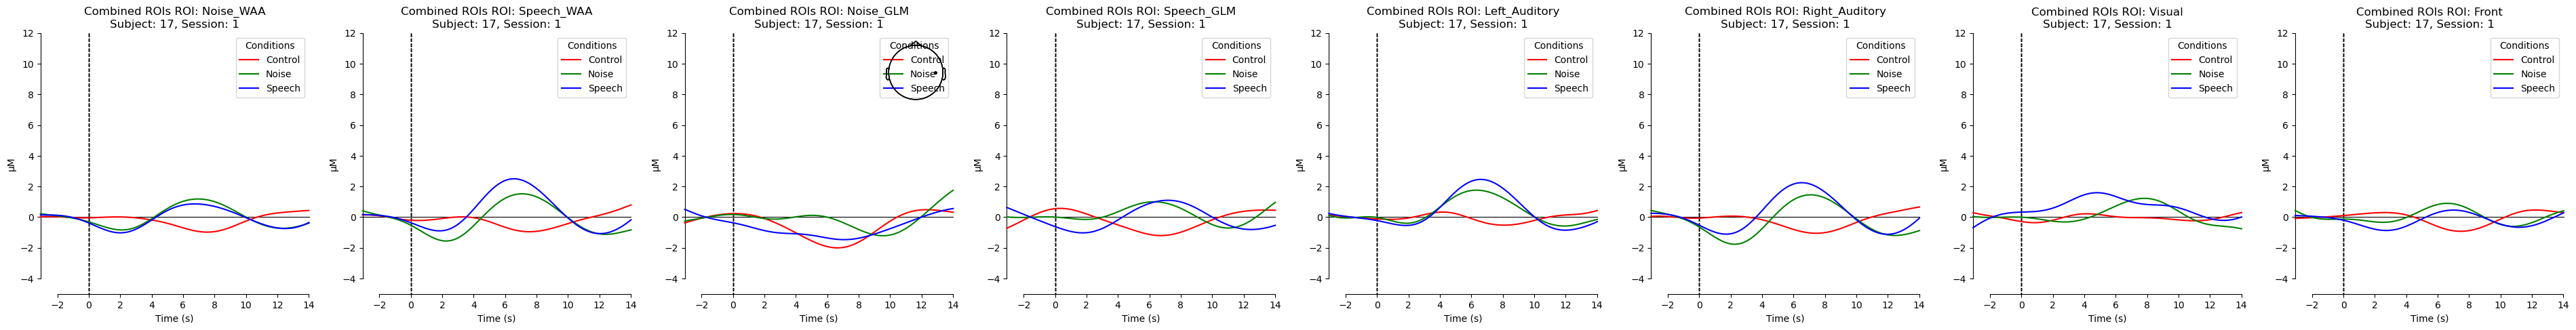

Subject 17, Session 02 - Rejected 0 epochs in Control
Subject 17, Session 02 - Rejected 0 epochs in Noise
Subject 17, Session 02 - Rejected 0 epochs in Speech


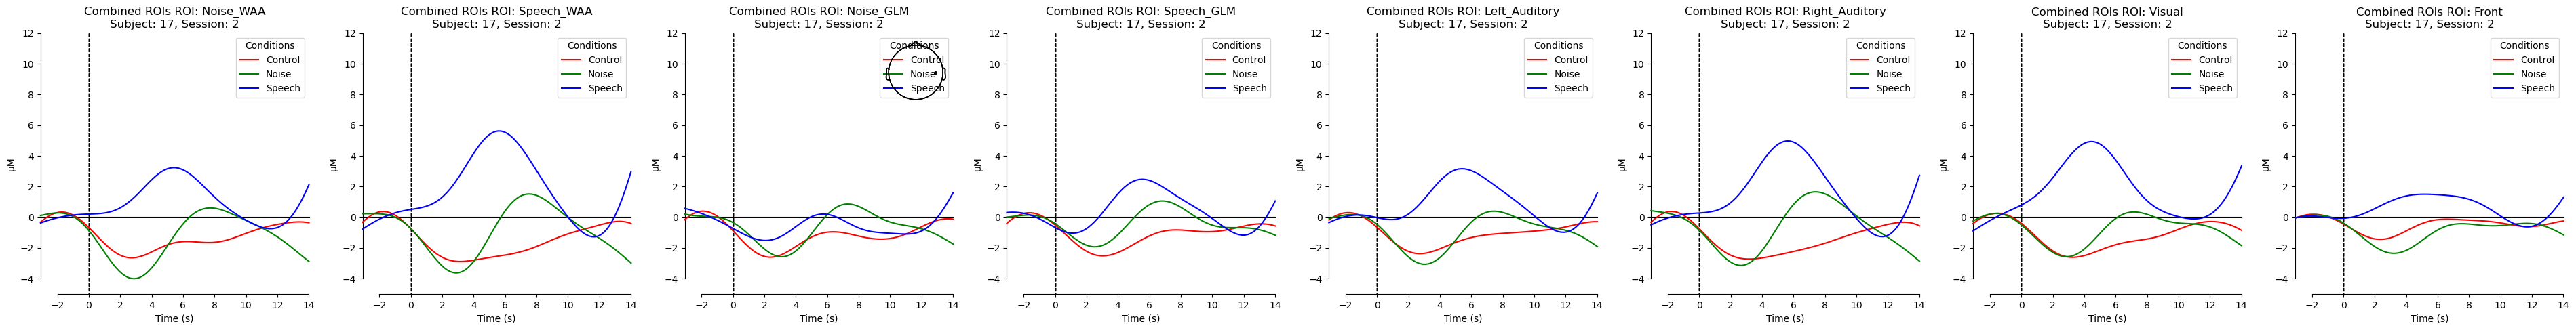

Subject 19, Session 01 - Rejected 1 epochs in Control
Subject 19, Session 01 - Rejected 1 epochs in Noise
Subject 19, Session 01 - Rejected 0 epochs in Speech


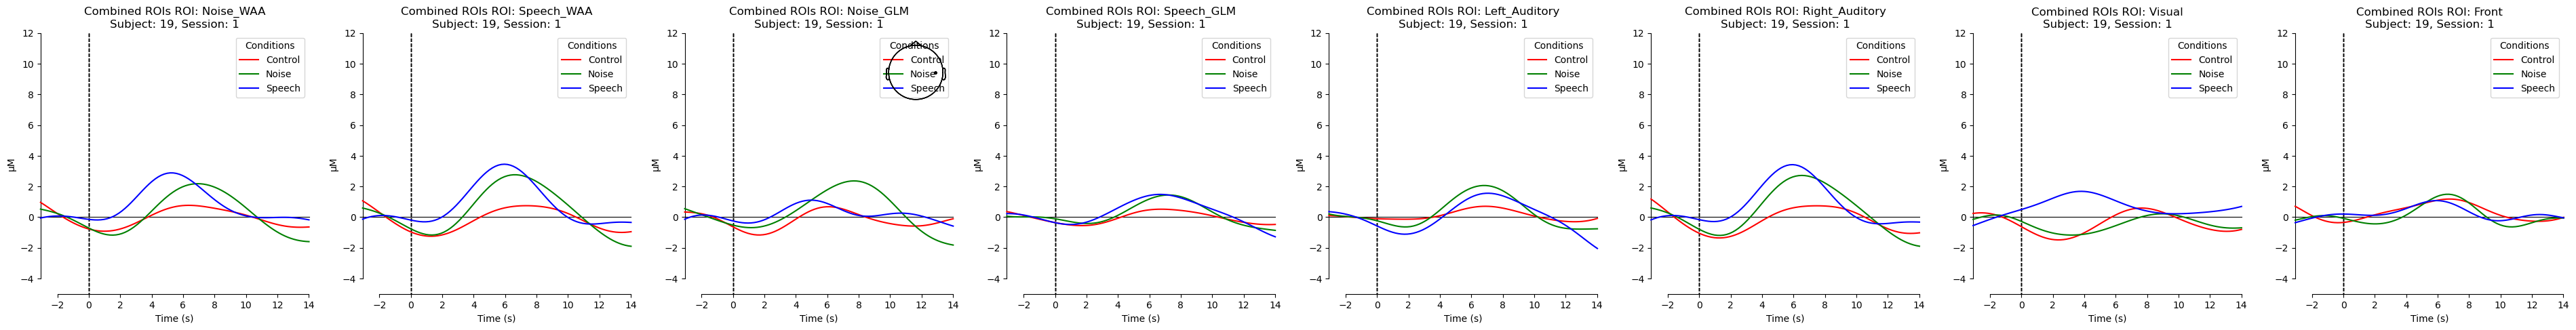

Subject 19, Session 02 - Rejected 0 epochs in Control
Subject 19, Session 02 - Rejected 0 epochs in Noise
Subject 19, Session 02 - Rejected 0 epochs in Speech


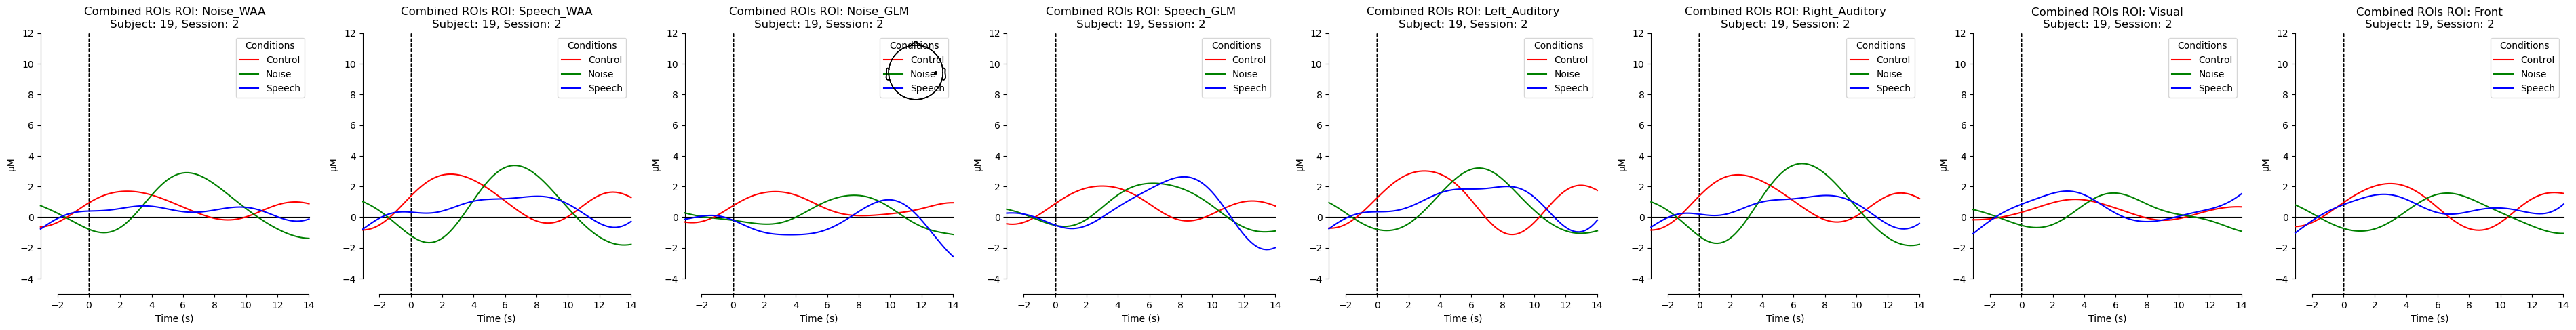

Subject 21, Session 01 - Rejected 2 epochs in Control
Subject 21, Session 01 - Rejected 1 epochs in Noise
Subject 21, Session 01 - Rejected 0 epochs in Speech


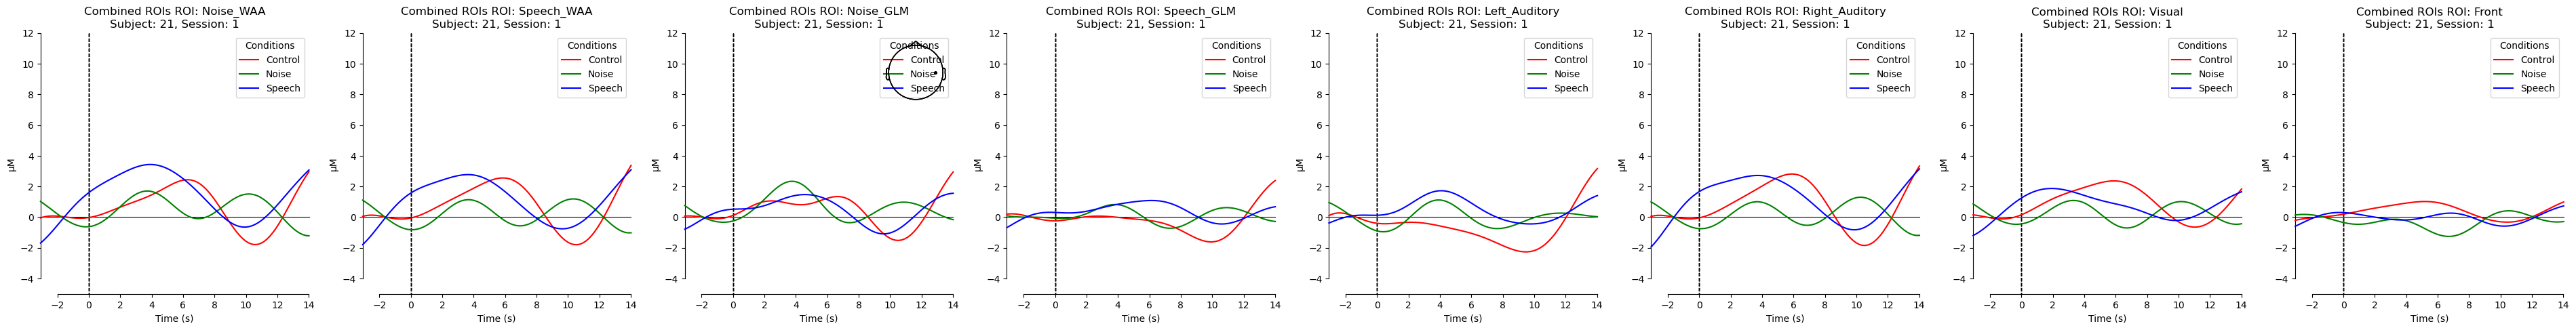

Subject 21, Session 02 - Rejected 1 epochs in Control
Subject 21, Session 02 - Rejected 1 epochs in Noise
Subject 21, Session 02 - Rejected 1 epochs in Speech


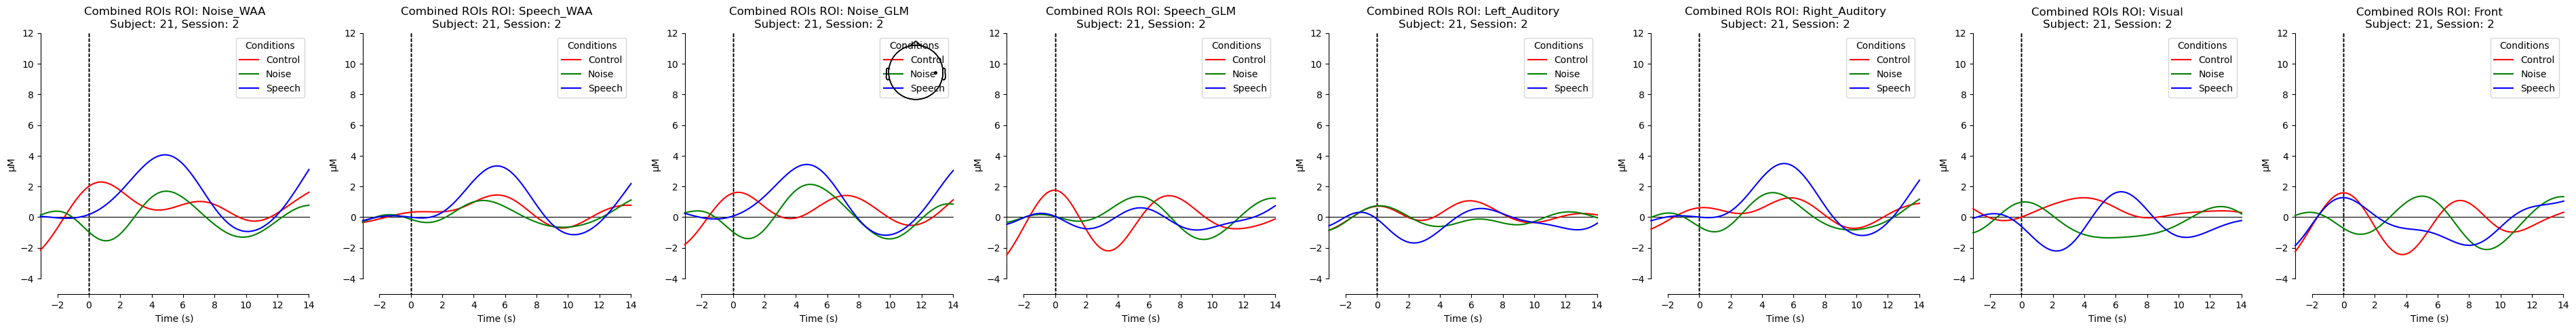

Subject 24, Session 01 - Rejected 0 epochs in Control
Subject 24, Session 01 - Rejected 0 epochs in Noise
Subject 24, Session 01 - Rejected 0 epochs in Speech


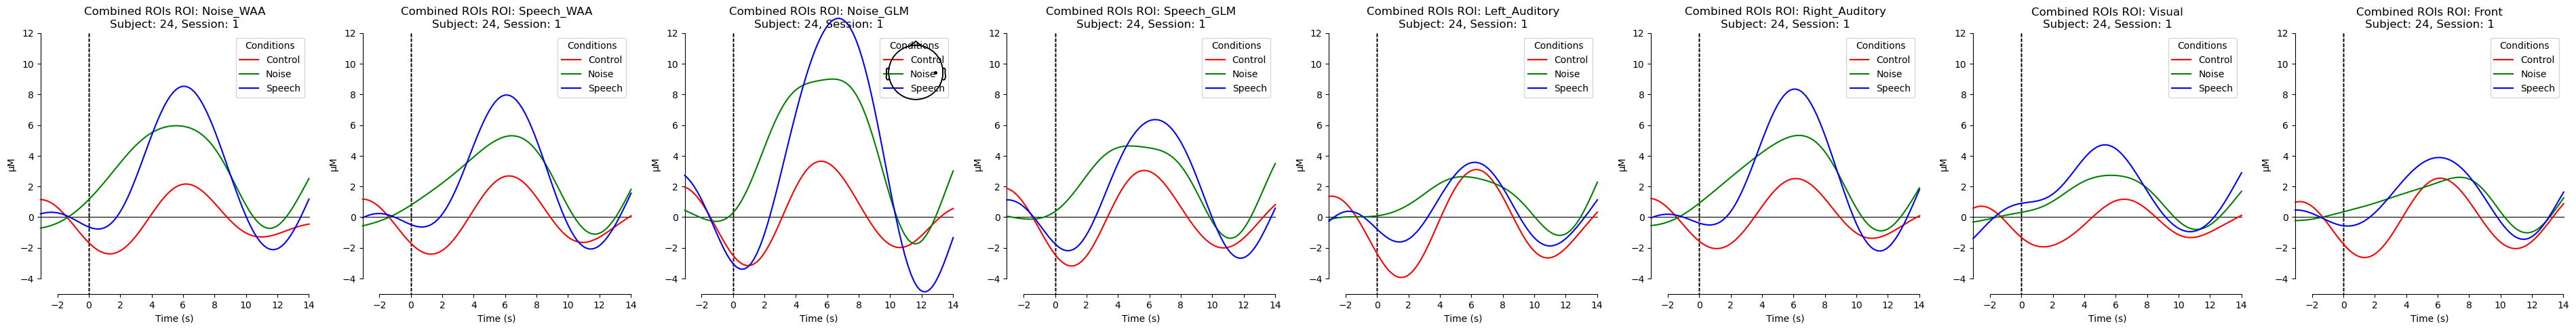

Subject 24, Session 02 - Rejected 1 epochs in Control
Subject 24, Session 02 - Rejected 1 epochs in Noise
Subject 24, Session 02 - Rejected 0 epochs in Speech


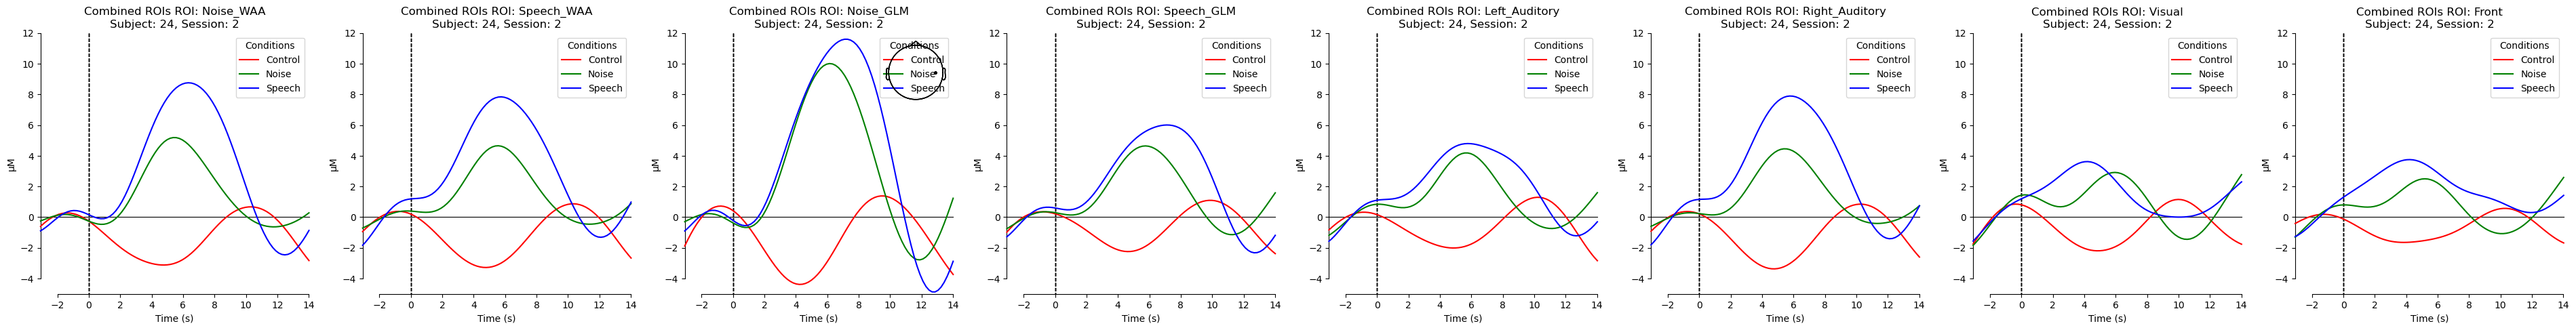


=== Significant ROI Summary per Participant ===

Subject: 01, Session: 01
  - Noise_WAA (Control vs Noise): p = 0.0000, effect = 8.2506 (↑)
  - Noise_WAA (Control vs Speech): p = 0.0006, effect = 7.2330 (↑)
  - Speech_WAA (Control vs Noise): p = 0.0000, effect = 8.1010 (↑)
  - Speech_WAA (Control vs Speech): p = 0.0000, effect = 7.9421 (↑)
  - Speech_GLM (Control vs Noise): p = 0.0000, effect = 4.2043 (↑)
  - Speech_GLM (Control vs Speech): p = 0.0001, effect = 4.4489 (↑)
  - Left_Auditory (Control vs Noise): p = 0.0000, effect = 5.8756 (↑)
  - Left_Auditory (Control vs Speech): p = 0.0006, effect = 5.7777 (↑)
  - Right_Auditory (Control vs Noise): p = 0.0000, effect = 8.4201 (↑)
  - Right_Auditory (Control vs Speech): p = 0.0001, effect = 7.7635 (↑)
  - Visual (Control vs Noise): p = 0.0000, effect = 6.5401 (↑)
  - Visual (Control vs Speech): p = 0.0001, effect = 5.7725 (↑)

Subject: 01, Session: 02
  - Noise_WAA (Control vs Speech): p = 0.0164, effect = 3.7285 (↑)
  - Speech_WAA (Co

In [68]:
bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
print("Detected subjects:", subject_list)

id=0
all_data = pd.DataFrame()
ttest_results = []
roi_mean_values = []


for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue

       # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()
        #speech_glm= [[6, 8], [9, 8]] 
        #noise_glm=[[6, 8]] 
        data_driven_rois = {
            "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
            "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
            "Noise_GLM": ["S11_D11 hbo"],
            "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S4_D2 hbo", "S4_D3 hbo", "S7_D7 hbo"],
            }
        
        predefined_rois = {
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"]
        }
        
        all_rois= {**data_driven_rois, **predefined_rois}

        
        
        plot_evoked_rois(
            evoked_dict=indiv_evoked_after,
            roi_definitions=all_rois,
            title_prefix="Combined ROIs",
            subject=sub,
            session=ses
        )
        
        ## ttest for significant differences between conditions
        tmin, tmax = 4, 6
        for roi_name, optode_list in all_rois.items():
            available_optodes = [opt for opt in optode_list if opt in epochs_cleaned.info["ch_names"]]
            if len(available_optodes) < 2:
                continue

            try:
                cond_data = {}
                cond_means = {}
                
                for cond in ["Control", "Noise", "Speech"]:
                    cond_epochs = epochs_cleaned[cond].copy().pick(available_optodes).crop(tmin=tmin, tmax=tmax)
                    data = cond_epochs.get_data()
                    roi_values = data.mean(axis=1).mean(axis=1) * 1e6  # µM
                    cond_data[cond] = roi_values
                    cond_means[cond] = np.mean(roi_values)

                # Store mean values for summary
                roi_mean_values.append({
                    "Subject": sub,
                    "Session": f"{ses:02d}",
                    "ROI": roi_name,
                    "Mean_Control": cond_means["Control"],
                    "Mean_Noise": cond_means["Noise"],
                    "Mean_Speech": cond_means["Speech"]
                })

                # Run t-tests
                if len(cond_data["Control"]) > 1 and len(cond_data["Noise"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Noise"], equal_var=False, alternative='less')
                    effect = cond_means["Noise"] - cond_means["Control"]
                    ttest_results.append({
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Noise", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

                if len(cond_data["Control"]) > 1 and len(cond_data["Speech"]) > 1:
                    t_stat, p_val = ttest_ind(cond_data["Control"], cond_data["Speech"], equal_var=False, alternative='less')
                    effect = cond_means["Speech"] - cond_means["Control"]
                    ttest_results.append({
                        "Subject": sub, "Session": f"{ses:02d}", "ROI": roi_name,
                        "Comparison": "Control vs Speech", "t_stat": t_stat,
                        "p_value": p_val, "Effect": effect
                    })

            except Exception as e:
                print(f"Error testing {roi_name} for Subject {sub}, Session {ses:02d}: {e}")

# === Save results ===
df_ttest = pd.DataFrame(ttest_results)

df_roi_means = pd.DataFrame(roi_mean_values)





# === Summary per participant ===
print("\n=== Significant ROI Summary per Participant ===")
df_significant = df_ttest[df_ttest["p_value"] < 0.05]
if df_significant.empty:
    print("No significant ROIs found.")
else:
    grouped = df_significant.groupby(["Subject", "Session"])
    for (sub, ses), group in grouped:
        print(f"\nSubject: {sub}, Session: {ses}")
        for _, row in group.iterrows():
            sign = "↑" if row["Effect"] > 0 else "↓"
            print(f"  - {row['ROI']} ({row['Comparison']}): p = {row['p_value']:.4f}, effect = {row['Effect']:.4f} ({sign})")




# WAA Group-Level Analysis (pre-defined vs data-driven ROIs)

In [47]:

bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"

# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

#subject_list = subject_list[:1]  # Limit to first subject for now
print("Detected subjects:", subject_list)
id=0

all_data = pd.DataFrame()

for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue


        # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
            "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
            "Noise_GLM": ["S6_D8 hbo"],
            "Speech_GLM": ["S6_D8 hbo", "S9_D8 hbo"],           
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
        }
        
                
        

        df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])

        id=id+1 
        
        for condition_name in ["Control", "Noise", "Speech"]:
            evoked = epochs_cleaned[condition_name].average()

            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                # Keep only optodes that exist in this subject/session
                valid_optodes = [ch for ch in optodes if ch in available_channels]
                
                if not valid_optodes:
                    print(f"⚠️ No valid optodes for ROI '{roi_name}' in Subject {sub}. Skipping this ROI.")
                    continue  # Skip if no optodes available

                for chroma in ["hbo"]:
                    try:
                        evoked_roi = deepcopy(evoked).pick(picks=valid_optodes).pick(chroma)
                        mean_val = evoked_roi.copy().crop(tmin=4, tmax=6.0).data.mean() * 1.0e6  # µM

                        df = pd.concat(
                            [
                                df,
                                pd.DataFrame(
                                    {
                                        "ID": [id],
                                        "Subject": [sub],
                                        "Session": f"{ses:02d}",
                                        "ROI": [roi_name],
                                        "Chroma": [chroma],
                                        "Condition": [condition_name],
                                        "Value": [mean_val],
                                    }
                                ),
                            ],
                            ignore_index=True,
                        )
                        
                    

                    except Exception as e:
                        print(f"❌ Failed to process ROI '{roi_name}' with error: {e}")
                    
        all_data = pd.concat([all_data, df], ignore_index=True)
                    



Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 2 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
⚠️ No valid optodes for ROI 'Noise_GLM' in Subject 01. Skipping this ROI.
⚠️ No valid optodes for ROI 'Speech_GLM' in Subject 01. Skipping this ROI.
⚠️ No valid optodes for ROI 'Noise_GLM' in Subject 01. Skipping this ROI.
⚠️ No valid optodes for ROI 'Speech_GLM' in Subject 01. Skipping this ROI.
⚠️ No valid optodes for ROI 'Noise_GLM' in Subject 01. Skipping this ROI.
⚠️ No valid optodes for ROI 'Speech_GLM' in Subject 01. Skipping this ROI.
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, S

## Plotting ROI average accross participants

Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Subject 01, Session 01 - Rejected 2 epochs in Control
Subject 01, Session 01 - Rejected 1 epochs in Noise
Subject 01, Session 01 - Rejected 1 epochs in Speech
Subject 01, Session 02 - Rejected 2 epochs in Control
Subject 01, Session 02 - Rejected 1 epochs in Noise
Subject 01, Session 02 - Rejected 1 epochs in Speech
Subject 02, Session 01 - Rejected 1 epochs in Control
Subject 02, Session 01 - Rejected 1 epochs in Noise
Subject 02, Session 01 - Rejected 0 epochs in Speech
Subject 02, Session 02 - Rejected 1 epochs in Control
Subject 02, Session 02 - Rejected 1 epochs in Noise
Subject 02, Session 02 - Rejected 0 epochs in Speech
Subject 03, Session 01 - Rejected 0 epochs in Control
Subject 03, Session 01 - Rejected 2 epochs in Noise
Subject 03, Session 01 - Rejected 0 epochs in Speech
Subject 03, Session 02 - Rejected 0 epochs in Control
Subject 03, Session 02 - Rejected 0

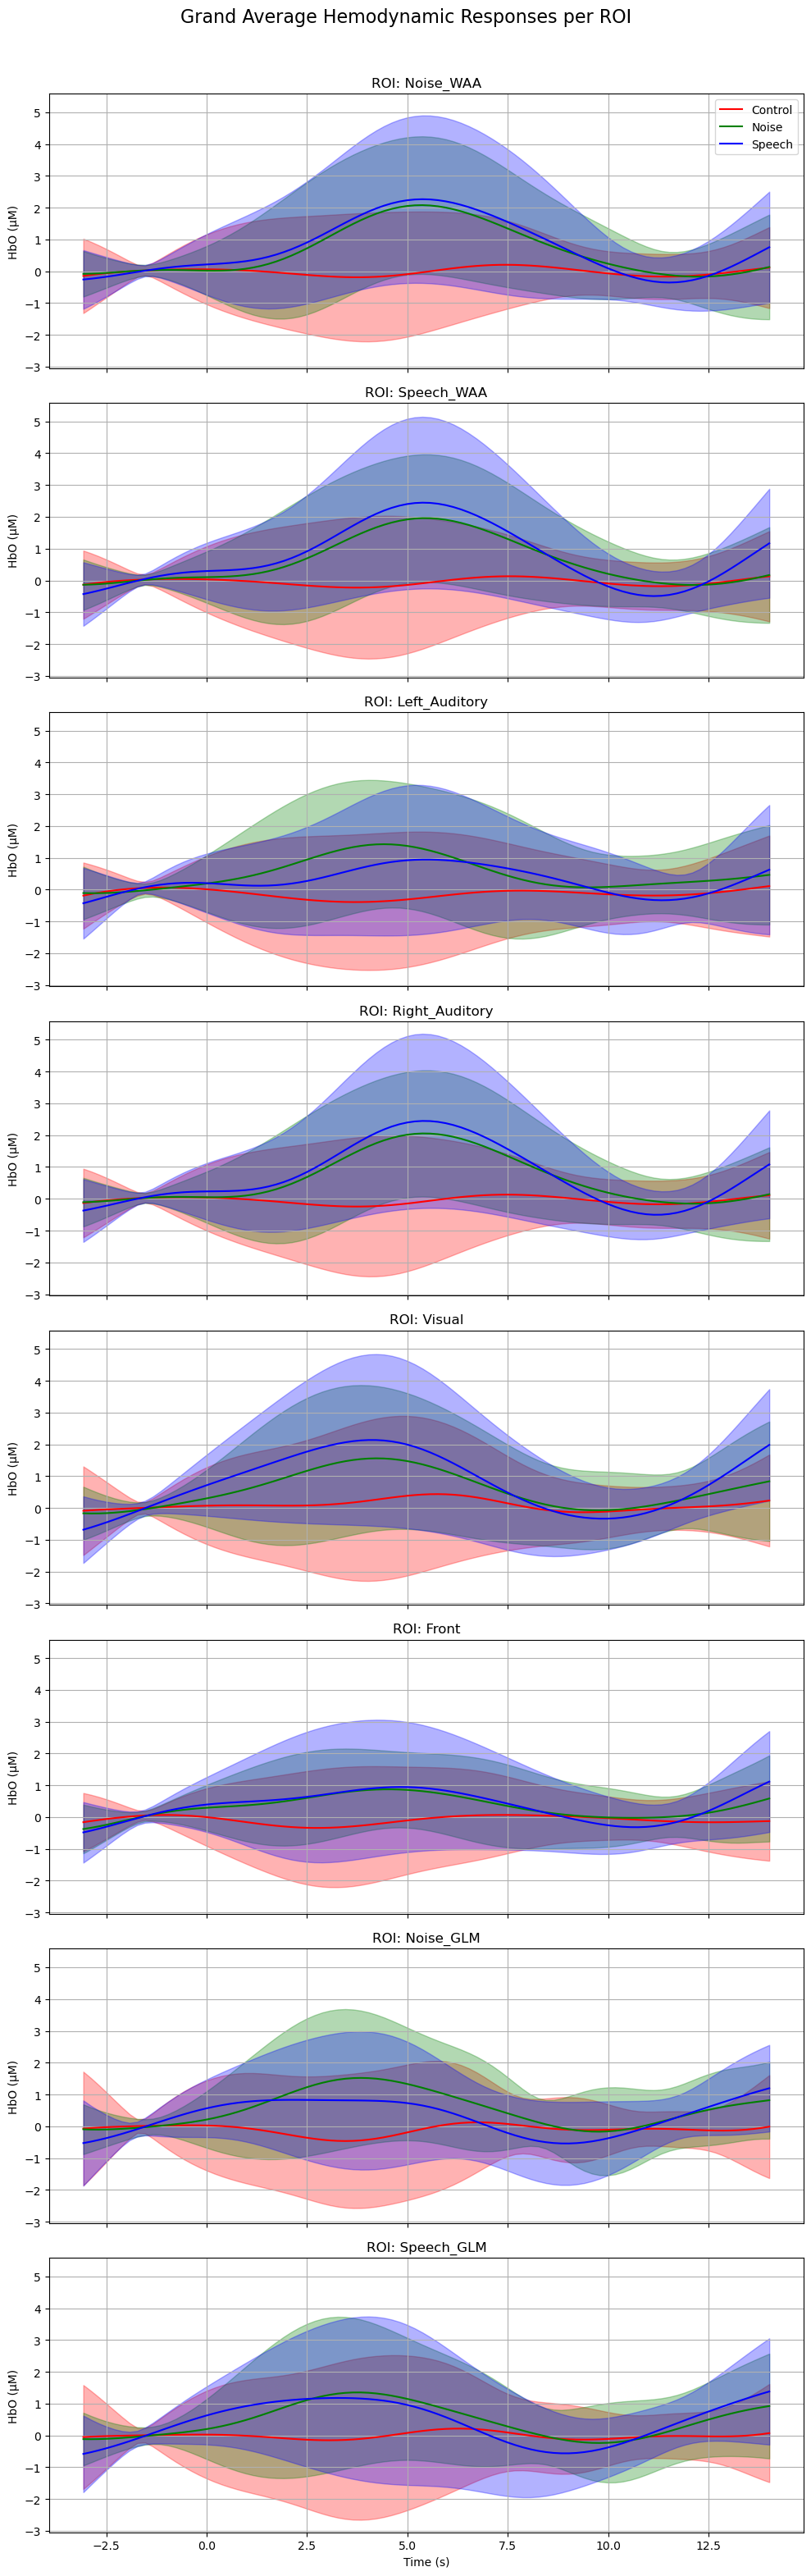

In [48]:

bids_root = r"C:\\Datasets\\Test-retest study\\bids_dataset"


# ROI -> Condition -> list of mean time series (numpy arrays)
roi_condition_timeseries = defaultdict(lambda: defaultdict(list))
time_vector = None  # Save once


# Get subject folders from the dataset
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]  # Extract subject numbers

#subject_list = subject_list[:1]  # Limit to first subject for now
print("Detected subjects:", subject_list)
id=0


for sub in subject_list:
    for ses in range(1, 3):
        bids_path = BIDSPath(
            subject=sub,
            session=f"{ses:02d}",
            task="auditory",
            datatype="nirs",
            root=bids_root,
            suffix="nirs",
            extension=".snirf",
        )

        epochs_cleaned, event_dict = full_preprocessing_individual(bids_path, z_thresh=2, stats_df=stats_df)

        if epochs_cleaned is None:
            print(f"⚠️ Skipping {bids_path.basename} (no valid epochs after cleaning)")
            continue


        # === Plot AFTER cleaning ===
        indiv_evoked_after = defaultdict(list)
        for condition in event_dict:
            indiv_evoked_after[condition] = epochs_cleaned[condition].average()

        rois = {
            "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
            "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
            "Noise_GLM": ["S6_D8 hbo"],
            "Speech_GLM": ["S6_D8 hbo", "S9_D8 hbo"],
            "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
            "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
            "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
            "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
        }
        
                
        

        df = pd.DataFrame(columns=["ID", "Subject", "Session", "ROI", "Chroma", "Condition", "Value"])

        id=id+1 
        
        # Inside your main loop, after creating indiv_evoked_after
        for condition_name, evoked in indiv_evoked_after.items():
            available_channels = evoked.info["ch_names"]

            for roi_name, optodes in rois.items():
                picks = [ch for ch in optodes if ch in available_channels]
                if not picks:
                    continue
                try:
                    evoked_roi = deepcopy(evoked).pick(picks=picks).pick("hbo")
                    mean_ts = evoked_roi.data.mean(axis=0)  # Mean over channels
                    roi_condition_timeseries[roi_name][condition_name].append(mean_ts)

                    # Save the time vector once
                    if time_vector is None:
                        time_vector = evoked_roi.times

                except Exception as e:
                    print(f"❌ Failed to process ROI '{roi_name}' ({condition_name}): {e}")

                    



colors = {"Control": "r", "Noise": "g", "Speech": "b"}

num_rois = len(roi_condition_timeseries)
fig, axes = plt.subplots(nrows=num_rois, ncols=1, figsize=(10, 4 * num_rois), sharex=True, sharey=True)
if num_rois == 1:
    axes = [axes]  # Ensure it's iterable

for ax, (roi_name, condition_dict) in zip(axes, roi_condition_timeseries.items()):
    for condition_name, ts_list in condition_dict.items():
        ts_array = np.vstack(ts_list)
        mean_ts = ts_array.mean(axis=0) * 1e6  # Convert to µM
        std_ts = ts_array.std(axis=0) * 1e6    # Convert to µM

        ax.plot(time_vector, mean_ts, label=condition_name, color=colors.get(condition_name, 'k'))
        ax.fill_between(time_vector, mean_ts - std_ts, mean_ts + std_ts,
                        color=colors.get(condition_name, 'k'), alpha=0.3)

    ax.set_title(f"ROI: {roi_name}")
    ax.set_ylabel("HbO (µM)")
    ax.grid(True)

axes[-1].set_xlabel("Time (s)")
axes[0].legend(loc='upper right')
plt.suptitle("Grand Average Hemodynamic Responses per ROI", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for supertitle
plt.show()




## LME

In [49]:

rois = {
    "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
    "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
    "Noise_GLM": ["S6_D8 hbo"],
    "Speech_GLM": ["S6_D8 hbo", "S9_D8 hbo"],
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}

# Loop through each ROI and run the model
for roi_name, channels in rois.items():
    # Filter for current ROI
    subset = all_data[
        (all_data["Chroma"] == "hbo") &
        (all_data["ROI"] == roi_name)
    ].copy()

    if subset.empty:
        print(f"\nROI: {roi_name} -> No data available for analysis.")
        continue

    # Ensure categorical
    subset["Condition"] = subset["Condition"].astype("category")
    subset["Session"] = subset["Session"].astype("category")

    try:
        # Fit the mixed model
        model = smf.mixedlm("Value ~ Condition + Session + Condition*Session", subset, groups=subset["Subject"])
        result = model.fit(method="nm")
        print(f"\n--- Summary for ROI: {roi_name} ---")
        print(result.summary())
    except Exception as e:
        print(f"\n--- Error fitting model for ROI: {roi_name} ---")
        print(str(e))



--- Summary for ROI: Noise_WAA ---
                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Value    
No. Observations:        96             Method:                    REML     
No. Groups:              16             Scale:                     3.7677   
Min. group size:         6              Log-Likelihood:            -203.9978
Max. group size:         6              Converged:                 Yes      
Mean group size:         6.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.352    0.561  0.628 0.530 -0.747  1.452
Condition[T.Noise]                 1.678    0.686  2.445 0.015  0.333  3.023
Condition[T.Speech]                2.218    0.686  3.232 0.0

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



--- Summary for ROI: Noise_GLM ---
                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Value    
No. Observations:        90             Method:                    REML     
No. Groups:              16             Scale:                     3.7173   
Min. group size:         3              Log-Likelihood:            -182.4603
Max. group size:         6              Converged:                 Yes      
Mean group size:         5.6                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.117    0.500  0.235 0.814 -0.862  1.097
Condition[T.Noise]                 1.155    0.704  1.640 0.101 -0.225  2.535
Condition[T.Speech]                0.856    0.704  1.216 0.2

In [78]:
df_combined

ID  Subject  Session  Optode Chroma Condition     Value
0      1        1        1   S4_D2    hbo   Control  0.833580
1      1        1        1   S4_D3    hbo   Control -2.053137
2      1        1        1   S5_D2    hbo   Control -5.128447
3      1        1        1   S5_D3    hbo   Control -1.963100
4      1        1        1   S5_D4    hbo   Control -3.274194
...   ..      ...      ...     ...    ...       ...       ...
2209  32       24        2   S1_D1    hbo    Speech  8.074650
2210  32       24        2   S2_D1    hbo    Speech  0.853441
2211  32       24        2   S3_D1    hbo    Speech  2.137650
2212  32       24        2   S3_D2    hbo    Speech  2.846795
2213  32       24        2  S12_D1    hbo    Speech  3.428102

[2214 rows x 7 columns]

# ICC analysis

In [80]:
mean_values

Subject  Session Condition     Value
0         1        2   Control  1.463363
1         1        2     Noise  2.518531
2         1        2    Speech  2.028737
3         2        1   Control -0.185955
4         2        1     Noise -0.043956
..      ...      ...       ...       ...
85       24        1     Noise  0.883655
86       24        1    Speech  0.277045
87       24        2   Control -1.302238
88       24        2     Noise  1.326891
89       24        2    Speech  2.476099

[90 rows x 4 columns]

In [ ]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
    "Noise_WAA": [ "S10_D11 hbo", "S11_D11 hbo","S10_D9 hbo" ],
    "Speech_WAA": ["S10_D10 hbo", "S10_D11 hbo",  "S10_D12 hbo", "S10_D9 hbo", "S11_D11 hbo", "S11_D12 hbo", "S5_D4 hbo"],
    "Noise_GLM": ["S11_D11 hbo"],
    "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S4_D2 hbo", "S4_D3 hbo", "S7_D7 hbo"],
    
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "Session", "Condition"])["Value"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "Session": "raters",
        "Value": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores")

    icc_3_1 = icc[icc["Type"] == "ICC3"].iloc[0]  # ICC(3,1)

    results_list.append({
        "ROI": roi_name,
        "ICC": icc_3_1["ICC"],
        "CI95_low": icc_3_1["CI95%"][0],
        "CI95_high": icc_3_1["CI95%"][1],
        "F": icc_3_1["F"],
        "pval": icc_3_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: Noise_WAA
Processing ROI: Speech_WAA
Processing ROI: Noise_GLM
Processing ROI: Speech_GLM
Processing ROI: Left_Auditory
Processing ROI: Right_Auditory
Processing ROI: Visual
Processing ROI: Front
✅ ICC results saved to 'icc_results_combined_conditions.csv'


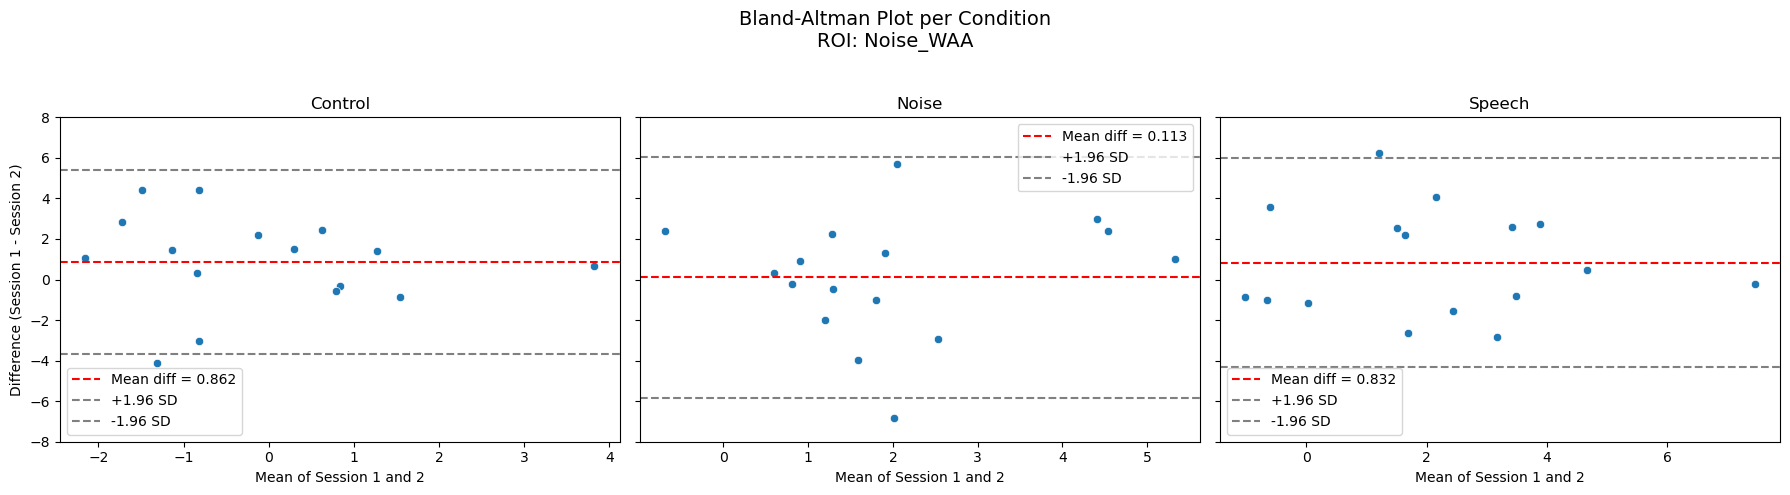

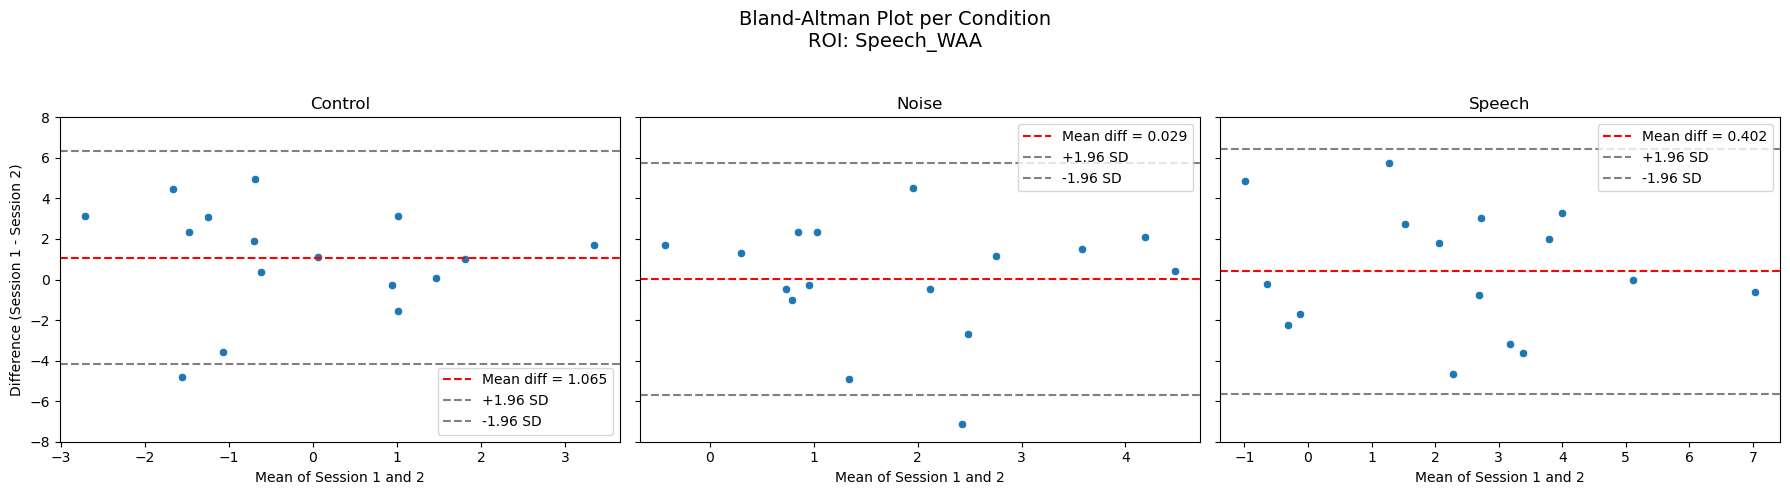

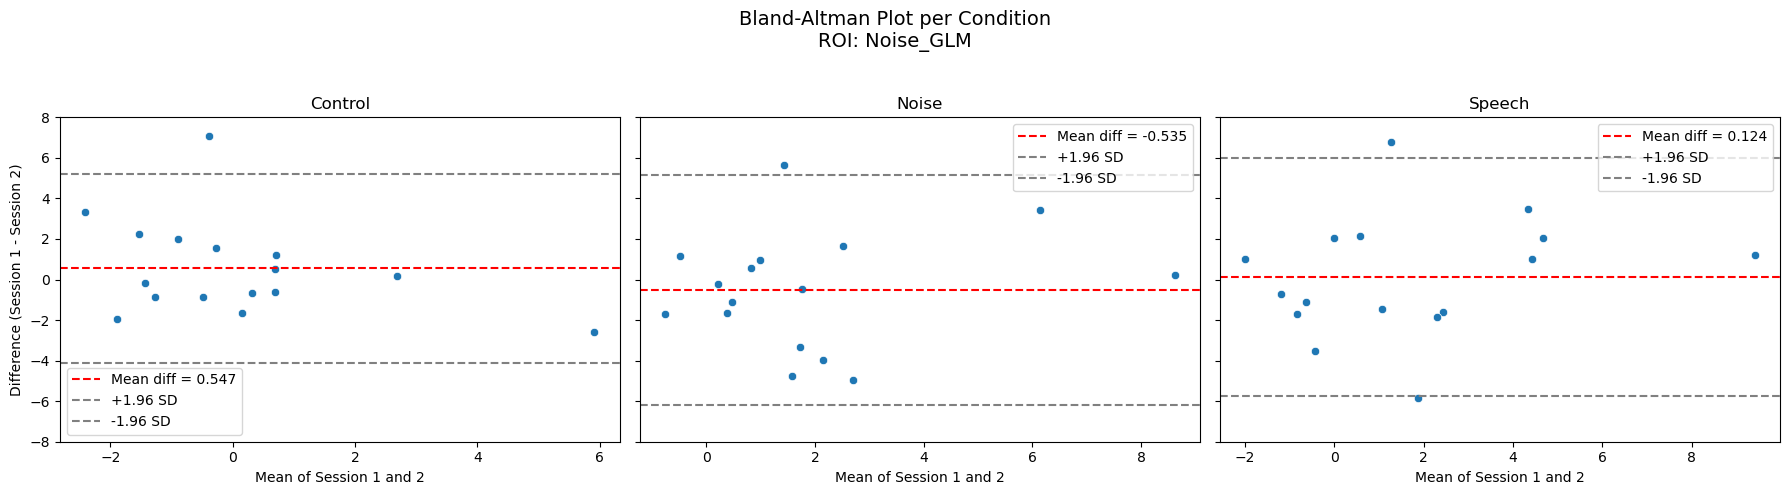

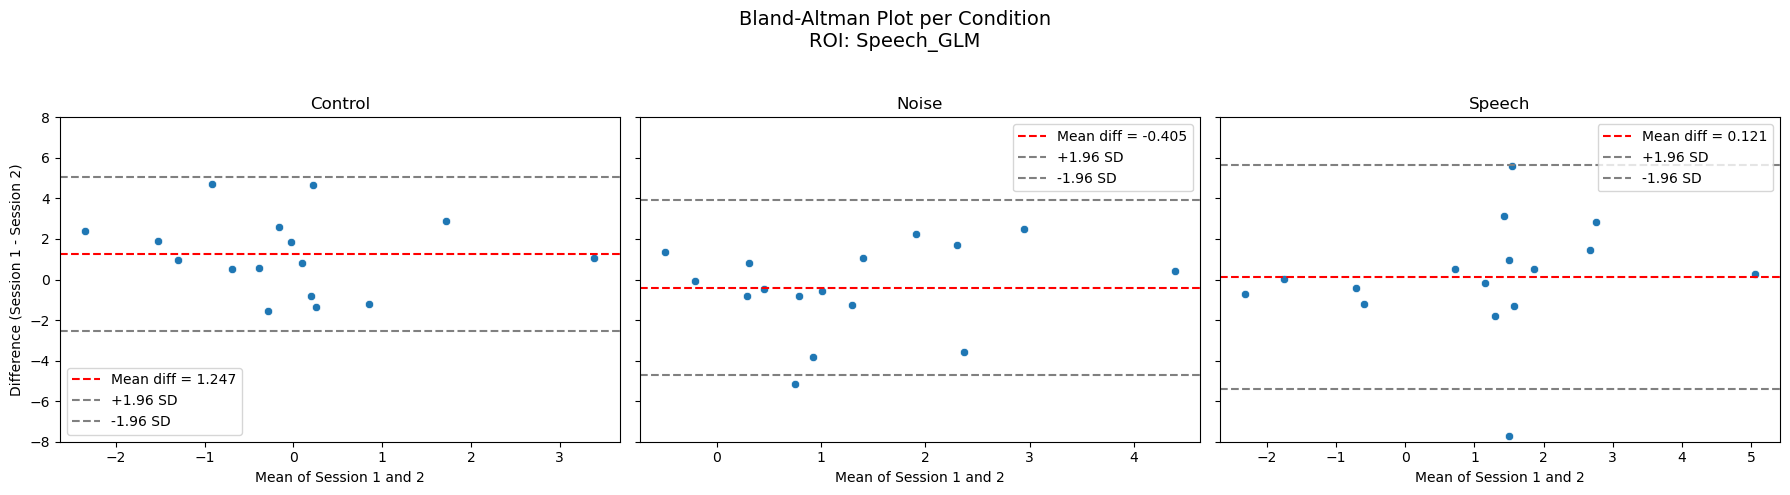

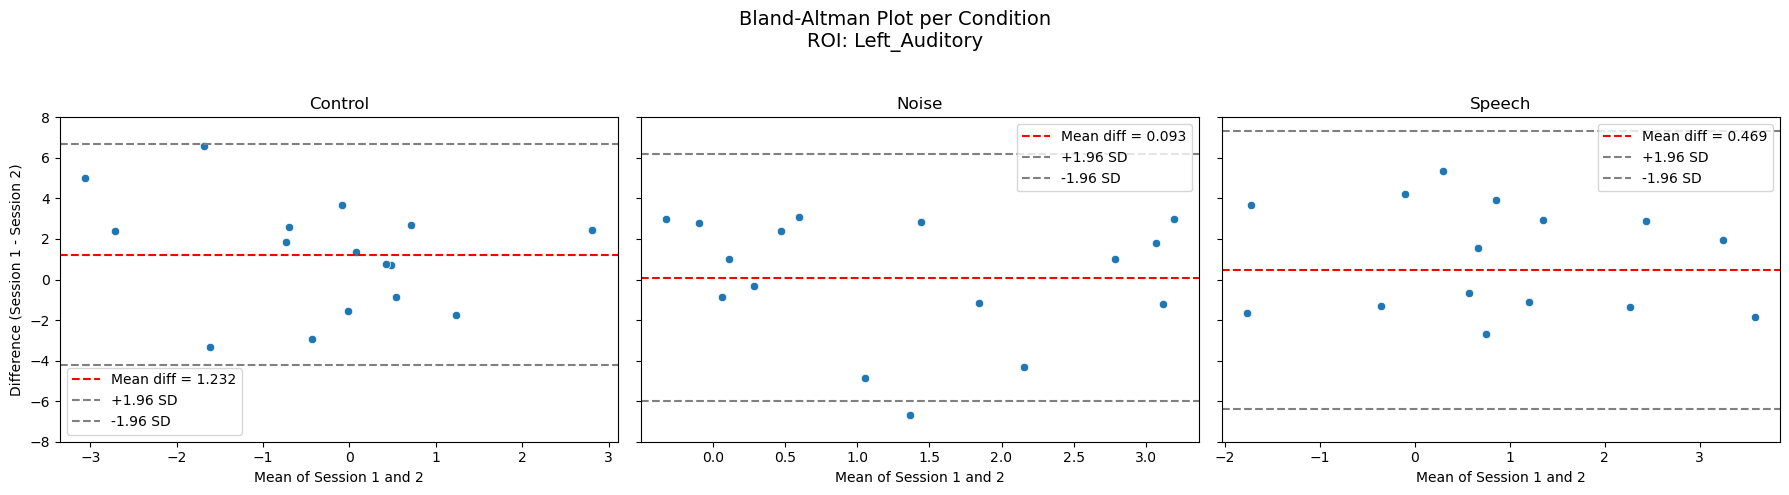

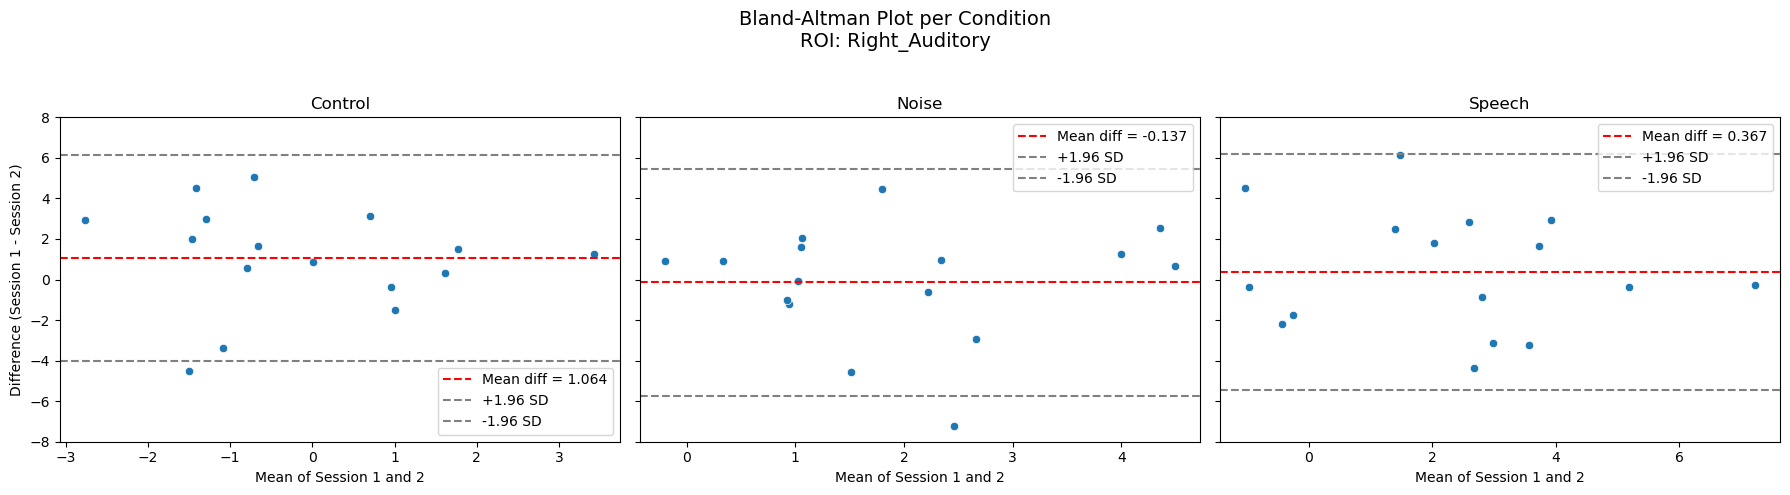

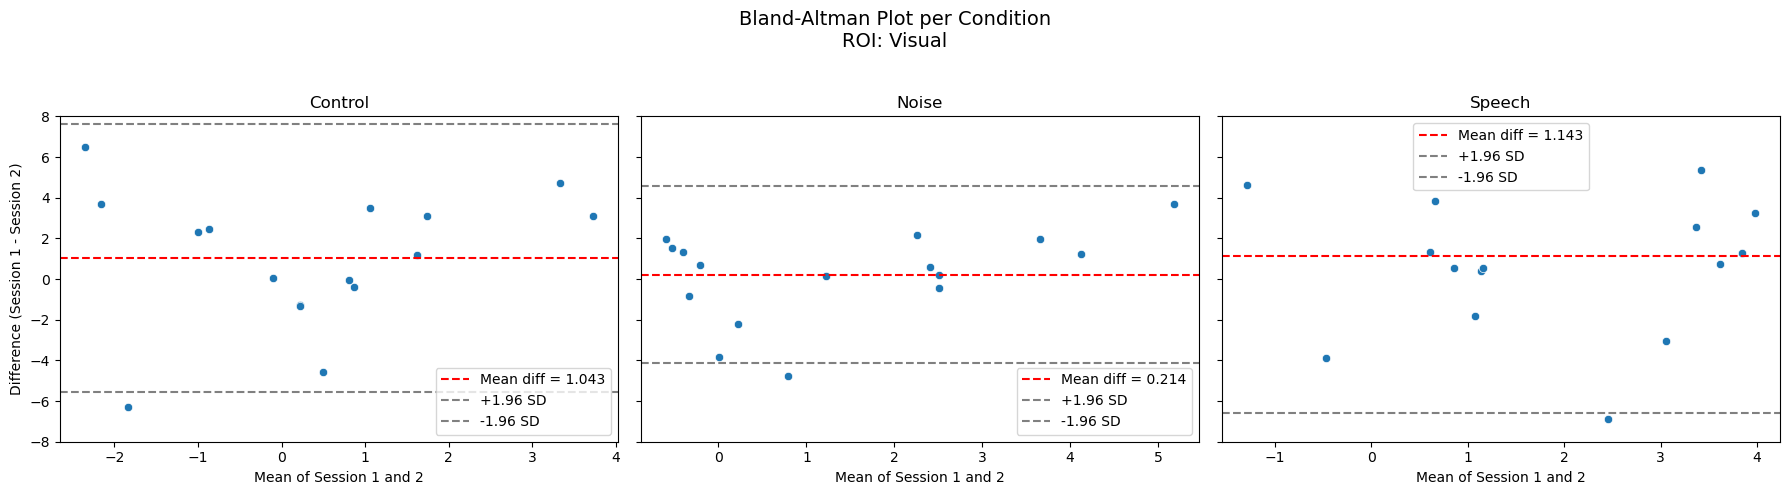

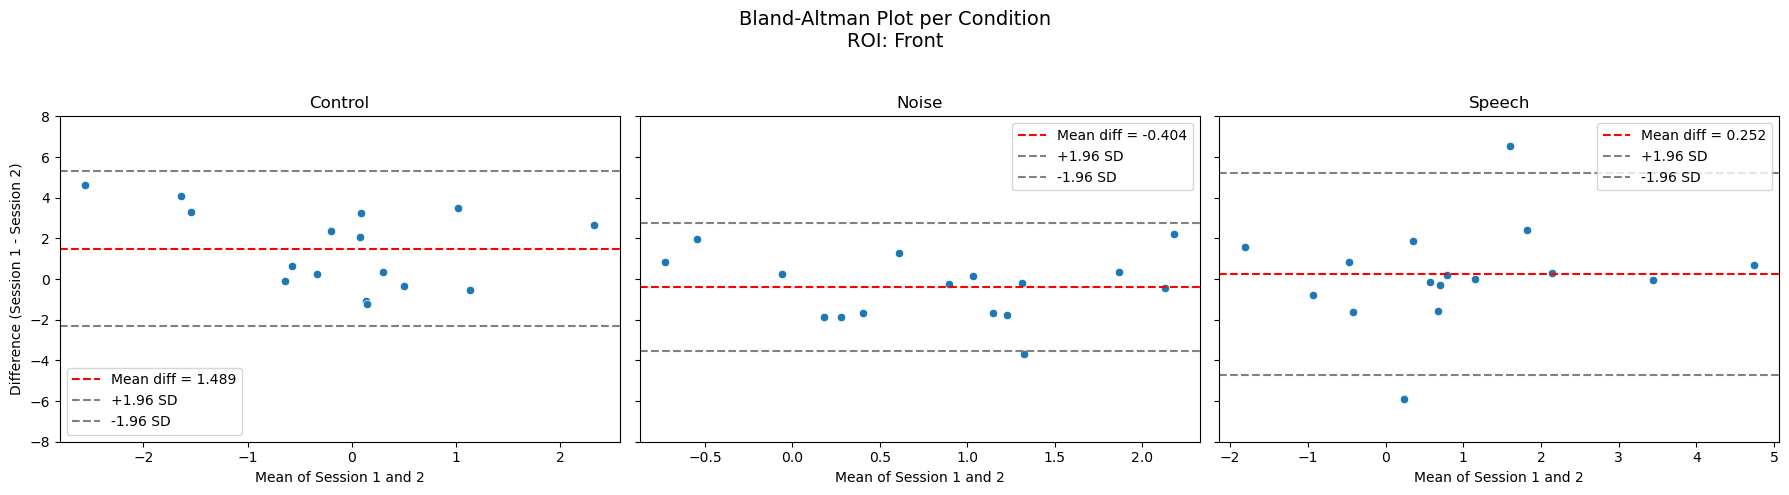

In [84]:
# Get unique experimental conditions
conditions = df_combined["Condition"].unique()
df_combined["Session"] = df_combined["Session"].astype(str).str.zfill(2)

# --- Bland-Altman plots per ROI and condition ---
for roi_name, optodes in rois.items():
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5), sharey=True)
    if len(conditions) == 1:
        axes = [axes]  # Ensure iterable if only one condition

    for ax, condition in zip(axes, conditions):
        # Filter data for current ROI and condition
        subset = df_combined[
            (df_combined["Optode"].isin(optodes)) & 
            (df_combined["Condition"] == condition)
        ]

        # Average over optodes for each subject and session
        mean_vals = subset.groupby(["Subject", "Session"])["Value"].mean().reset_index()

        # Pivot so each subject has session 01 and 02 as columns
        pivot = mean_vals.pivot(index="Subject", columns="Session", values="Value").dropna()

        if pivot.shape[0] < 2:
            ax.set_title(f'{condition}\nNot enough data')
            ax.axis('off')
            continue

        # Bland-Altman calculations
        session1 = pivot["01"]
        session2 = pivot["02"]
        avg = (session1 + session2) / 2
        diff = session1 - session2
        mean_diff = diff.mean()
        std_diff = diff.std()

        # Plot
        sns.scatterplot(x=avg, y=diff, ax=ax)
        ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.3f}')
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
        ax.set_title(f'{condition}')
        ax.set_xlabel('Mean of Session 1 and 2')
        if ax == axes[0]:
            ax.set_ylabel('Difference (Session 1 - Session 2)')
            ax.set_ylim(-8, 8)
        else:
            ax.set_ylabel('')
        ax.legend()

    plt.suptitle(f'Bland-Altman Plot per Condition\nROI: {roi_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
